In [53]:
import pandas as pd
from datetime import datetime as dt
import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from datetime import timedelta
from scipy.stats import wilcoxon
from sklearn.linear_model import LinearRegression
from statsmodels.stats.api import het_white
from statsmodels.stats.api import durbin_watson
from scipy.stats import shapiro

In [54]:
# https://www.cryptoarchive.com.au/asset/DOGE --> Doge EUR
folderpath = "../../Data/QMEF/"

df = pd.read_csv(folderpath + 'DOGEUSDT.csv', sep='|', header=None)

# https://www.cryptoarchive.com.au/faq
df.columns = ['timestamp', 'Open', 'High', 'Low', 'Close', 'Volume', 'Taker Buy Quote Asset Volume', 
                'Taker Buy Base Asset Volume', 'Quote Asset Volume', 'Number of trades']
# Quote Asset Volume verwenden. Volume ist im Verhältnis zu BTC.

df_btc = pd.read_csv(folderpath + 'BTCUSDT.csv', sep='|', header=None)

# https://www.cryptoarchive.com.au/faq
df_btc.columns = ['timestamp', 'Open', 'High', 'Low', 'Close', 'Volume', 'Taker Buy Quote Asset Volume', 
                'Taker Buy Base Asset Volume', 'Quote Asset Volume', 'Number of trades']
                
# Quote Asset Volume verwenden. Volume ist im Verhältnis zu BTC.

In [55]:
df_tweets = pd.read_csv("../../Data/QMEF/doge_tweet_analysis.csv", sep=";", encoding='utf8', parse_dates=['CreatedAt', 'UTC'])
df_tweets.drop_duplicates('TweetId', inplace = True)

df_tweets['timestamp'] = df_tweets['UTC'].apply(lambda x: x.astype('int')//10**9)
df_tweets['timestamp'] = df_tweets['timestamp'] - (df_tweets['timestamp'] % 60) #Abrunden auf Minuten

df_tweets = df_tweets[['UTC', 'timestamp', 'Text', 'Favorites', 'Retweets', 'neg', 'neu', 'pos', 'compound']]

df_tweets['UTC'] = pd.to_datetime(df_tweets['UTC'])

# Zeitdauer von 6 Stunden
time_threshold = timedelta(hours=6)

# Liste für Zeilen, die behalten werden sollen
df_tweets_relevant = []

# Iteriere über jeden Eintrag im DataFrame
for index, row in df_tweets.iterrows():
    utc_time = row['UTC']
    
    # Überprüfe die Differenz zur 'UTC'-Spalte aller anderen Einträge
    time_difference = abs(df_tweets.loc[df_tweets.index != index, 'UTC'] - utc_time)
    
    # Wenn die Differenz größer oder gleich 6 Stunden ist, behalte den Eintrag
    if (time_difference >= time_threshold).all():
        df_tweets_relevant.append(index)

# Filtere den DataFrame nach den ausgewählten Zeilen
df_tweets_relevant = df_tweets.loc[df_tweets_relevant]

df_tweets_relevant.drop([3, 18], inplace=True) # Löschen der Tweets, weil in der Doge-Coin-Zeitreihe hier Preise fehlen.

pd.set_option('display.max_colwidth', None)
print(df_tweets_relevant)

                         UTC   timestamp  \
4  2021-02-20 08:42:28+00:00  1613810520   
5  2021-02-06 08:42:25+00:00  1612600920   
6  2021-03-15 23:11:50+00:00  1615849860   
7  2021-03-01 19:57:08+00:00  1614628620   
8  2021-02-08 05:27:36+00:00  1612762020   
9  2021-02-10 15:08:11+00:00  1612969680   
10 2021-04-28 06:20:47+00:00  1619590800   
11 2020-11-17 18:45:21+00:00  1605638700   
12 2021-05-11 08:13:35+00:00  1620720780   
13 2021-03-02 21:07:09+00:00  1614719220   
14 2021-03-02 08:36:34+00:00  1614674160   
15 2021-05-13 22:45:16+00:00  1620945900   
16 2021-03-18 21:17:16+00:00  1616102220   
17 2021-02-11 23:27:37+00:00  1613086020   
24 2021-04-01 10:25:23+00:00  1617272700   
27 2021-05-09 22:41:43+00:00  1620600060   
28 2021-02-21 21:27:06+00:00  1613942820   
31 2021-02-07 22:25:14+00:00  1612736700   
32 2020-12-20 09:30:04+00:00  1608456600   

                                                                                                                       

In [56]:
df['Date'] = df['timestamp'].apply(lambda x: dt.fromtimestamp(x))

ar_ges = pd.DataFrame(columns=['AR_0', 'AR_1', 'AR_2', 'AR_3', 'AR_4', 'AR_5', 'AR_6', 'AR_7', 'AR_8', 'AR_9', 'AR_10', ])
car_ges = pd.DataFrame(columns = ['CAR_1', 'CAR_2', 'CAR_5', 'CAR_10', 'CAR_30', 'CAR_60', 'CAR_120'])

cum_abnormal_returns_all = []

for _, tweet in df_tweets_relevant.iterrows():
    timestamp = tweet['timestamp']
    doge_sliced = df[(df['timestamp'] >= timestamp-360*60) & (df['timestamp'] <= timestamp+120*60)]
    
    # Ausrechnen der Renditen
    doge_sliced['log_returns'] = np.log(doge_sliced['Close'] / doge_sliced['Close'].shift(1))
    # Erste Rendite wird 0 gesetzt
    doge_sliced.loc[0, 'log_returns'] = 0
    # Kumulierte Renditen
    doge_sliced['cum_log_returns'] = np.cumsum(doge_sliced['log_returns'])

    # Expected Returns which are based on the mean value of the returns of the last 5 hours before the tweet.
    # Event Takes place at t=360
    expected_return = np.mean(doge_sliced['log_returns'].iloc[1:301]) # Fehler bei Ante, da Ante 1:301 nimmt und nicht 0:300
    print('Expected Return = ', expected_return)
    
    # Abnormal Returns based on After Returns - Mean Value of Returns (before Tweet)
    doge_sliced['abnormal_returns'] = doge_sliced['log_returns'] - expected_return
    doge_sliced['abnormal_returns_cum'] = np.cumsum(doge_sliced['abnormal_returns'])
    doge_sliced['abnormal_returns_cum'].iloc[0] = 0

    cum_abnormal_returns_all.append(doge_sliced['abnormal_returns_cum'].values)

    ar_values = []
    for event_horizon in range(11):
        ar_values.append(doge_sliced['abnormal_returns'].iloc[360+event_horizon])
    ar_ges = pd.concat([ar_ges, pd.DataFrame([ar_values], columns=ar_ges.columns)], ignore_index=True)


    car_values = []
    for event_horizon in [1, 2, 5, 10, 30, 60, 120]:
        car_values.append(doge_sliced['abnormal_returns'].iloc[360:360+event_horizon+1].sum())
    car_ges = pd.concat([car_ges, pd.DataFrame([car_values], columns=car_ges.columns)], ignore_index=True)

    # T-Statistiken für [1, 5, 10, 30, 60, 120]
    for event_horizon in [1, 5, 10, 30, 60, 120]:
        print(f'T[0; {event_horizon}] = ', (doge_sliced['abnormal_returns'].iloc[360:360+event_horizon+1].mean() / doge_sliced['abnormal_returns'].iloc[360:360+event_horizon+1].std()) * np.sqrt(event_horizon+1)) # <-- richtiger Wert


    # fig = plt.figure(1, figsize = (25, 11))
    # plt.plot(doge_sliced["Date"], doge_sliced['cum_log_returns'], lw=2, label='Cumulative Returns')
    # plt.plot(doge_sliced["Date"], doge_sliced['abnormal_returns_cum'], lw=2, label='Cumulative Abnormal Returns', color='darkred')
    # plt.vlines(dt.fromtimestamp(timestamp), label='Tweet', ymin=doge_sliced['cum_log_returns'].min()*1.2, ymax=doge_sliced['cum_log_returns'].max()*1.2, colors='red', lw=2) 

    # if len(tweets_sliced) > 1:
    #     plt.vlines([dt.fromtimestamp(i) for i in tweets_sliced['timestamp'] if i != timestamp], label='Other Tweets', ymin=0, ymax=doge_sliced['abnormal_returns_cum'].max()*1.2, colors='orange', lw=2) 
    # plt.axhline(0, color = 'black')
    # plt.legend(loc='best', fontsize=20)
    # plt.title('Cumulative Returns', size=25)

    # plt.show()

# print('ar_frame:')
# print(ar_ges)

# print('car_frame:')
# print(car_ges)

C:\Users\ckopp\AppData\Local\Temp\ipykernel_7308\1928748985.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doge_sliced['log_returns'] = np.log(doge_sliced['Close'] / doge_sliced['Close'].shift(1))
C:\Users\ckopp\AppData\Local\Temp\ipykernel_7308\1928748985.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doge_sliced.loc[0, 'log_returns'] = 0
C:\Users\ckopp\AppData\Local\Temp\ipykernel_7308\1928748985.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pyd

Expected Return =  0.0001166578310119093
T[0; 1] =  4.239183201792826
T[0; 5] =  1.5747751753185093
T[0; 10] =  2.6926451838140664
T[0; 30] =  0.7137333526559749
T[0; 60] =  0.5369900128056214
T[0; 120] =  0.026008854642363053
Expected Return =  0.00011954122636684032
T[0; 1] =  -0.16328146644376756
T[0; 5] =  -1.2711323826031402
T[0; 10] =  -1.112601150300769
T[0; 30] =  -1.285370986835372
T[0; 60] =  -0.7091467927746506
T[0; 120] =  0.3157255846133703


C:\Users\ckopp\AppData\Local\Temp\ipykernel_7308\1928748985.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doge_sliced.loc[0, 'log_returns'] = 0
C:\Users\ckopp\AppData\Local\Temp\ipykernel_7308\1928748985.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doge_sliced['abnormal_returns_cum'].iloc[0] = 0
C:\Users\ckopp\AppData\Local\Temp\ipykernel_7308\1928748985.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

Expected Return =  5.7995718885262655e-05
T[0; 1] =  1.4188780114235486
T[0; 5] =  1.4813755728600884
T[0; 10] =  0.45768563865361056
T[0; 30] =  0.04662629527319552
T[0; 60] =  -0.11489864064116766
T[0; 120] =  -1.06582919318792
Expected Return =  -5.2747043932395145e-05
T[0; 1] =  3.471426411820988
T[0; 5] =  0.6734820962033435
T[0; 10] =  0.5624173985724984
T[0; 30] =  0.34635942840628403
T[0; 60] =  0.31852174071716244
T[0; 120] =  0.6646279246344333


C:\Users\ckopp\AppData\Local\Temp\ipykernel_7308\1928748985.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doge_sliced.loc[0, 'log_returns'] = 0
C:\Users\ckopp\AppData\Local\Temp\ipykernel_7308\1928748985.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doge_sliced['abnormal_returns_cum'].iloc[0] = 0
C:\Users\ckopp\AppData\Local\Temp\ipykernel_7308\1928748985.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

Expected Return =  -0.0004238815129562764
T[0; 1] =  -0.23640227061358837
T[0; 5] =  -0.2141006362264407
T[0; 10] =  -0.4867143689719467
T[0; 30] =  -0.6541440681748888
T[0; 60] =  0.1716399118983704
T[0; 120] =  -0.2102634891077464
Expected Return =  -6.435561389600386e-05
T[0; 1] =  4.17580273808606
T[0; 5] =  1.462504480269266
T[0; 10] =  1.5420922000109087
T[0; 30] =  0.8478133502814132
T[0; 60] =  0.7335102491624159
T[0; 120] =  0.6442803298185706
Expected Return =  -7.125517873890502e-05


C:\Users\ckopp\AppData\Local\Temp\ipykernel_7308\1928748985.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doge_sliced['abnormal_returns_cum'].iloc[0] = 0
C:\Users\ckopp\AppData\Local\Temp\ipykernel_7308\1928748985.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doge_sliced['log_returns'] = np.log(doge_sliced['Close'] / doge_sliced['Close'].shift(1))
C:\Users\ckopp\AppData\Local\Temp\ipykernel_7308\1928748985.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

T[0; 1] =  2.057894214473867
T[0; 5] =  2.3135636062895784
T[0; 10] =  3.3267533243879055
T[0; 30] =  1.3131808463440517
T[0; 60] =  0.9673812016193302
T[0; 120] =  1.0346880213261402
Expected Return =  1.8498899864579395e-05
T[0; 1] =  -0.742858230226308
T[0; 5] =  0.34769274928255206
T[0; 10] =  0.3434943753487658
T[0; 30] =  0.8439180096923926
T[0; 60] =  0.9135776921293787
T[0; 120] =  0.5134024010491871
Expected Return =  9.10511907813602e-05


C:\Users\ckopp\AppData\Local\Temp\ipykernel_7308\1928748985.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doge_sliced['abnormal_returns_cum'].iloc[0] = 0
C:\Users\ckopp\AppData\Local\Temp\ipykernel_7308\1928748985.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doge_sliced['log_returns'] = np.log(doge_sliced['Close'] / doge_sliced['Close'].shift(1))
C:\Users\ckopp\AppData\Local\Temp\ipykernel_7308\1928748985.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

T[0; 1] =  4.951959138097377
T[0; 5] =  4.39810827453629
T[0; 10] =  2.918633556439251
T[0; 30] =  1.4074052023364345
T[0; 60] =  1.0164040398520136
T[0; 120] =  0.9568517187046711
Expected Return =  -8.575581004954297e-05
T[0; 1] =  0.7647750857778668
T[0; 5] =  0.022201764625641413
T[0; 10] =  -0.16977535540298577
T[0; 30] =  -0.6460620992045436
T[0; 60] =  0.30451047639646006
T[0; 120] =  0.5881454626765883
Expected Return =  -0.00010039549519261607


C:\Users\ckopp\AppData\Local\Temp\ipykernel_7308\1928748985.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doge_sliced['abnormal_returns_cum'].iloc[0] = 0
C:\Users\ckopp\AppData\Local\Temp\ipykernel_7308\1928748985.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doge_sliced['log_returns'] = np.log(doge_sliced['Close'] / doge_sliced['Close'].shift(1))
C:\Users\ckopp\AppData\Local\Temp\ipykernel_7308\1928748985.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

T[0; 1] =  2.113333268326683
T[0; 5] =  1.0258720188655341
T[0; 10] =  0.877224295833998
T[0; 30] =  0.5812178387781481
T[0; 60] =  0.7533592923855481
T[0; 120] =  1.0635008610087908
Expected Return =  0.00010887077577759035
T[0; 1] =  36.55281316950707
T[0; 5] =  1.5140698722431378
T[0; 10] =  1.176575069870311
T[0; 30] =  1.3618579190372155
T[0; 60] =  0.8162765245107151
T[0; 120] =  0.8408349805896936
Expected Return =  -4.16072305960986e-05
T[0; 1] =  0.16153040822757547
T[0; 5] =  0.6979062495460139
T[0; 10] =  0.3200655677239611
T[0; 30] =  0.42702575838081386
T[0; 60] =  0.43417457183770564
T[0; 120] =  0.4538281960088398
Expected Return =  -4.17082796415421e-05
T[0; 1] =  0.7837267944480083
T[0; 5] =  0.7924927102959738
T[0; 10] =  0.33162665164075167
T[0; 30] =  0.29951329864468373
T[0; 60] =  0.019810139480682498
T[0; 120] =  -0.18680282408573773


C:\Users\ckopp\AppData\Local\Temp\ipykernel_7308\1928748985.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doge_sliced['abnormal_returns_cum'].iloc[0] = 0
C:\Users\ckopp\AppData\Local\Temp\ipykernel_7308\1928748985.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doge_sliced['log_returns'] = np.log(doge_sliced['Close'] / doge_sliced['Close'].shift(1))
C:\Users\ckopp\AppData\Local\Temp\ipykernel_7308\1928748985.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

Expected Return =  -1.6371252156740373e-05
T[0; 1] =  4.1542470959974205
T[0; 5] =  2.958943059495974
T[0; 10] =  2.32398132209881
T[0; 30] =  1.7585705002047394
T[0; 60] =  2.2041010885233048
T[0; 120] =  1.5182479258619295
Expected Return =  0.0003817275321941493
T[0; 1] =  5.341888777574503
T[0; 5] =  2.443118029056409
T[0; 10] =  0.8495380842379692
T[0; 30] =  0.2537131971035636
T[0; 60] =  -0.09489119750266413
T[0; 120] =  -0.6602655909157705


C:\Users\ckopp\AppData\Local\Temp\ipykernel_7308\1928748985.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doge_sliced['log_returns'] = np.log(doge_sliced['Close'] / doge_sliced['Close'].shift(1))
C:\Users\ckopp\AppData\Local\Temp\ipykernel_7308\1928748985.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doge_sliced.loc[0, 'log_returns'] = 0
C:\Users\ckopp\AppData\Local\Temp\ipykernel_7308\1928748985.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pyd

Expected Return =  -1.408314672051439e-05
T[0; 1] =  5.211132674486299
T[0; 5] =  0.9740316765177042
T[0; 10] =  0.6902910076976517
T[0; 30] =  0.448255229804778
T[0; 60] =  0.5482937402687413
T[0; 120] =  0.5473907514361356
Expected Return =  0.00031219382768720745


C:\Users\ckopp\AppData\Local\Temp\ipykernel_7308\1928748985.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doge_sliced['abnormal_returns_cum'].iloc[0] = 0
C:\Users\ckopp\AppData\Local\Temp\ipykernel_7308\1928748985.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doge_sliced['log_returns'] = np.log(doge_sliced['Close'] / doge_sliced['Close'].shift(1))
C:\Users\ckopp\AppData\Local\Temp\ipykernel_7308\1928748985.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://

T[0; 1] =  19.131575808068394
T[0; 5] =  1.090932677314183
T[0; 10] =  0.3055742311943549
T[0; 30] =  -0.16476521355672158
T[0; 60] =  -0.15375483830857314
T[0; 120] =  -0.8498693763890078
Expected Return =  1.83223221846963e-05
T[0; 1] =  4.222892007230923
T[0; 5] =  2.237424241569305
T[0; 10] =  3.0053547210254563
T[0; 30] =  1.9540934686438989
T[0; 60] =  1.6782716927793644
T[0; 120] =  0.9518271139073285


C:\Users\ckopp\AppData\Local\Temp\ipykernel_7308\1928748985.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doge_sliced.loc[0, 'log_returns'] = 0
C:\Users\ckopp\AppData\Local\Temp\ipykernel_7308\1928748985.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doge_sliced['abnormal_returns_cum'].iloc[0] = 0


In [58]:
cum_abnormal_returns_all_doge = pd.DataFrame(cum_abnormal_returns_all)
cum_abnormal_returns_all_btc = pd.read_csv('cum_abnormal_returns_all_btc.csv')


mean_car_doge = cum_abnormal_returns_all_doge.mean()
mean_car_btc = cum_abnormal_returns_all_btc.mean()
mean_car_all = (19*mean_car_doge.values+6*mean_car_btc.values)/25

fig = plt.figure(1, figsize = (25, 11))
plt.plot(mean_car_doge, lw=2, label='Dogecoin (n=19)')
plt.plot(mean_car_btc, lw=2, label='Bitcoin (n=6)')
plt.plot(mean_car_all, lw=2, label='All (n=25)')

plt.vlines(359.5, label='Tweet', ymin=mean_car_doge.min()*1.2, ymax=mean_car_doge.max()*1.2, colors='red', lw=1) 
plt.hlines(0, xmin = 0, xmax = 480, colors='grey')
plt.xticks([0, 60, 120, 180, 240, 300, 360, 420, 480], ['-360', '-300', '-240', '-180', '-120', '-60', '0', '60', '120'])
plt.yticks([-0.02, 0, 0.02, 0.04, 0.06], ['-2%', '0%', '2%', '4%', '6%'])
plt.legend(loc='best', fontsize=20)
plt.savefig('CAR_Übersicht.pdf')

FileNotFoundError: [Errno 2] No such file or directory: 'cum_abnormal_returns_all_btc.csv'

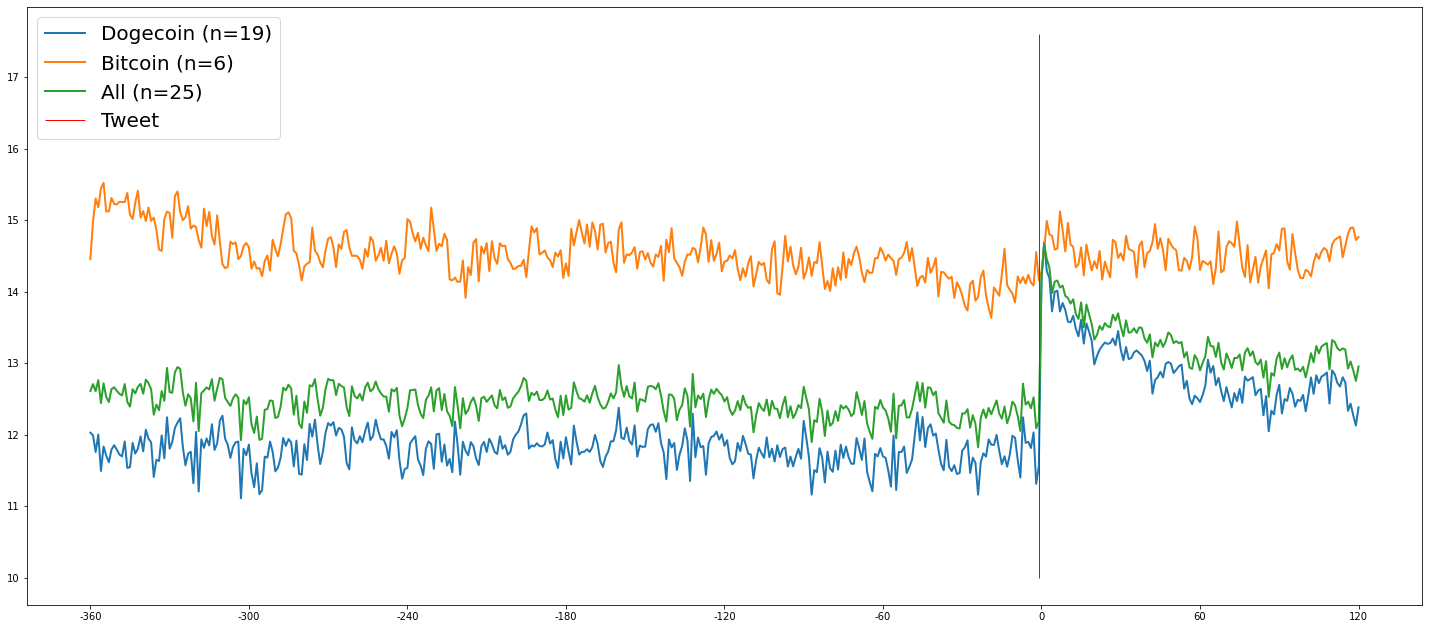

In [ ]:
cum_abnormal_volume_all_doge = pd.DataFrame(cum_abnormal_volume_all)
cum_abnormal_volume_all_btc = pd.read_csv('cum_abnormal_volume_all_btc.csv')


mean_catv_doge = cum_abnormal_volume_all_doge.mean()
mean_catv_btc = cum_abnormal_volume_all_btc.mean()

mean_catv_all = (19*mean_catv_doge.values+6*mean_catv_btc.values)/25

fig = plt.figure(1, figsize = (25, 11))
plt.plot(mean_catv_doge, lw=2, label='Dogecoin (n=19)')
plt.plot(mean_catv_btc, lw=2, label='Bitcoin (n=6)')
plt.plot(mean_catv_all, lw=2, label='All (n=25)')

plt.vlines(359, label='Tweet', ymin=10, ymax=mean_catv_all.max()*1.2, colors='red', lw=1) 
plt.xticks([0, 60, 120, 180, 240, 300, 360, 420, 480], ['-360', '-300', '-240', '-180', '-120', '-60', '0', '60', '120'])
# plt.yticks([-0.02, 0, 0.02, 0.04, 0.06], ['-2%', '0%', '2%', '4%', '6%'])
plt.legend(loc='upper left', fontsize=20)
plt.savefig('CATV_Übersicht.pdf')

In [ ]:
print(pd.DataFrame(cum_abnormal_volume_all))

    0         1         2         3         4         5         6         7    \
0   0.0  1.557824  1.119184  0.399920  0.390583  0.188061  0.631126  2.648887   
1   0.0 -2.831582 -4.694911 -5.711005 -6.642004 -6.876250 -7.245565 -7.386422   
2   0.0  0.892428  1.323604  1.384499  1.013486  0.882859  0.100936  0.090909   
3   0.0 -1.044703 -0.186261  1.186399  1.598344  3.117189  3.484768  4.115711   
4   0.0 -0.206383  0.178677  0.694262  0.899512  1.399426  1.620738  1.892562   
5   0.0  0.028135  0.066498  0.057469 -0.398535 -0.269543 -0.379454 -0.047660   
6   0.0  2.950076  2.827755  2.855989  3.260709  2.772493  2.536923  2.803397   
7   0.0  5.478107  3.704616  3.385424  3.351749  1.336423 -0.727222 -7.405988   
8   0.0 -0.369474 -0.233367 -0.295021  0.250020 -0.117665  0.539709  0.103518   
9   0.0 -1.846702 -2.060354 -2.476582 -2.531288 -2.972857 -2.785680 -2.855050   
10  0.0  1.859696  2.093444  2.639085  2.774692  3.243402  3.034490  4.019301   
11  0.0  2.286669  3.580804 

In [ ]:
for s in ar_ges.columns:
    print(s)
    print('mean: ', ar_ges[s].mean())
    print('pos: ', sum(ar_ges[s] > 0) / len(ar_ges[s]))
    print('t-stat: ' ,ar_ges[s].mean() / ar_ges[s].std() * np.sqrt(len(ar_ges[s])))

    test_statistic, p_value = wilcoxon(ar_ges[s], method='exact', alternative='two-sided')

    # Gib die Teststatistik und den p-Wert aus
    print("z-stat:", test_statistic)
    print("p-Wert:", p_value)
    print(np.round(ar_ges[s].mean()*100, 4), '\% & ', 
          np.round(ar_ges[s].mean() / ar_ges[s].std() * np.sqrt(len(ar_ges[s])), 2), ' & ',
          np.round(test_statistic, 2), ' & ',
          int(np.round(sum(ar_ges[s] > 0) / len(ar_ges[s])*100, 0)), '\%')
    print('\n')

AR_0
mean:  0.01870859708900443
pos:  1.0
t-stat:  5.747904145155615
z-stat: 0.0
p-Wert: 3.814697265625e-06
1.8709 \% &  5.75  &  0.0  &  100 \%


AR_1
mean:  0.015977179019294418
pos:  0.6842105263157895
t-stat:  3.7430818410100626
z-stat: 26.0
p-Wert: 0.003917694091796875
1.5977 \% &  3.74  &  26.0  &  68 \%


AR_2
mean:  0.007349791388806473
pos:  0.631578947368421
t-stat:  2.3435791676020434
z-stat: 51.0
p-Wert: 0.07987594604492188
0.735 \% &  2.34  &  51.0  &  63 \%


AR_3
mean:  0.0023944114092633124
pos:  0.5263157894736842
t-stat:  0.669976316367057
z-stat: 78.0
p-Wert: 0.5152778625488281
0.2394 \% &  0.67  &  78.0  &  53 \%


AR_4
mean:  0.0018125102515965444
pos:  0.5263157894736842
t-stat:  0.7287765827244401
z-stat: 77.0
p-Wert: 0.48996734619140625
0.1813 \% &  0.73  &  77.0  &  53 \%


AR_5
mean:  -0.0006109394851021823
pos:  0.47368421052631576
t-stat:  -0.24424927564164486
z-stat: 91.0
p-Wert: 0.8905677795410156
-0.0611 \% &  -0.24  &  91.0  &  47 \%


AR_6
mean:  -0.000

In [ ]:
for s in car_ges.columns:
      print(s)
      print('mean: ', car_ges[s].mean())
      print('pos: ', sum(car_ges[s] > 0) / len(car_ges[s]))
      print('t-stat: ' ,car_ges[s].mean() / car_ges[s].std() * np.sqrt(len(car_ges[s])))

      test_statistic, p_value = wilcoxon(car_ges[s], method='approx', alternative='two-sided')

      # Gib die Teststatistik und den p-Wert aus
      print("z-stat:", test_statistic)
      print("p-Wert:", p_value)
      print(np.round(car_ges[s].mean()*100, 4), '\% & ', 
            np.round(car_ges[s].mean() / car_ges[s].std() * np.sqrt(len(car_ges[s])), 2), ' & ',
            np.round(test_statistic, 2), ' & ',
            int(np.round(sum(car_ges[s] > 0) / len(car_ges[s])*100, 0)), '\%')
      print('\n')

CAR_1
mean:  0.034685776108298844
pos:  0.8421052631578947
t-stat:  4.864516719892128
z-stat: 7.0
p-Wert: 0.00039814247498266234
3.4686 \% &  4.86  &  7.0  &  84 \%


CAR_2
mean:  0.042035567497105304
pos:  0.8947368421052632
t-stat:  4.398299629377713
z-stat: 3.0
p-Wert: 0.0002136700043906972
4.2036 \% &  4.4  &  3.0  &  89 \%


CAR_5
mean:  0.04563154967286299
pos:  0.8947368421052632
t-stat:  4.537315227689752
z-stat: 7.0
p-Wert: 0.00039814247498266234
4.5632 \% &  4.54  &  7.0  &  89 \%


CAR_10
mean:  0.05071466274731709
pos:  0.8421052631578947
t-stat:  3.8513554181381324
z-stat: 12.0
p-Wert: 0.0008374789865327178
5.0715 \% &  3.85  &  12.0  &  84 \%


CAR_30
mean:  0.04439563031211417
pos:  0.7894736842105263
t-stat:  3.093081019321878
z-stat: 34.0
p-Wert: 0.014097354120504295
4.4396 \% &  3.09  &  34.0  &  79 \%


CAR_60
mean:  0.043837213744744905
pos:  0.7894736842105263
t-stat:  3.091519357953325
z-stat: 23.0
p-Wert: 0.0037622518256999957
4.3837 \% &  3.09  &  23.0  &  79 \%

In [ ]:
ar_total = pd.concat([ar_ges, pd.read_csv('ar_ges_bitcoin.csv')], ignore_index=True)
car_total = pd.concat([car_ges, pd.read_csv('car_ges_bitcoin.csv')], ignore_index=True)

In [ ]:
for s in ar_total.columns:
    print(s)
    print('mean: ', ar_total[s].mean())
    print('pos: ', sum(ar_total[s] > 0) / len(ar_total[s]))
    print('t-stat: ' ,ar_total[s].mean() / ar_total[s].std() * np.sqrt(len(ar_total[s])))

    test_statistic, p_value = wilcoxon(ar_total[s], method='exact', alternative='two-sided')

    # Gib die Teststatistik und den p-Wert aus
    print("z-stat:", test_statistic)
    print("p-Wert:", p_value)
    print(np.round(ar_total[s].mean()*100, 4), '\% & ', 
          np.round(ar_total[s].mean() / ar_total[s].std() * np.sqrt(len(ar_total[s])), 2), ' & ',
          np.round(test_statistic, 2), ' & ',
          int(np.round(sum(ar_total[s] > 0) / len(ar_total[s])*100, 0)), '\%')
    print('\n')

AR_0
mean:  0.01417144875676813
pos:  0.88
t-stat:  4.786419250923639
z-stat: 15.0
p-Wert: 8.165836334228516e-06
1.4171 \% &  4.79  &  15.0  &  88 \%


AR_1
mean:  0.011777004303837163
pos:  0.64
t-stat:  3.267569360532346
z-stat: 67.0
p-Wert: 0.008822321891784668
1.1777 \% &  3.27  &  67.0  &  64 \%


AR_2
mean:  0.005067513857882736
pos:  0.56
t-stat:  1.9772618955408408
z-stat: 111.0
p-Wert: 0.17295855283737183
0.5068 \% &  1.98  &  111.0  &  56 \%


AR_3
mean:  0.0016066274584105775
pos:  0.48
t-stat:  0.5904993625571984
z-stat: 146.0
p-Wert: 0.6720751523971558
0.1607 \% &  0.59  &  146.0  &  48 \%


AR_4
mean:  0.0017119860781198513
pos:  0.56
t-stat:  0.9008162944839017
z-stat: 126.0
p-Wert: 0.33878785371780396
0.1712 \% &  0.9  &  126.0  &  56 \%


AR_5
mean:  -0.0012949488319535466
pos:  0.4
t-stat:  -0.654105267771078
z-stat: 139.0
p-Wert: 0.5424043536186218
-0.1295 \% &  -0.65  &  139.0  &  40 \%


AR_6
mean:  -0.00040026546674001693
pos:  0.48
t-stat:  -0.2814676296376544
z-

In [ ]:
for s in car_total.columns:
      print(s)
      print('mean: ', car_total[s].mean())
      print('pos: ', sum(car_total[s] > 0) / len(car_total[s]))
      print('t-stat: ' ,car_total[s].mean() / car_total[s].std() * np.sqrt(len(car_total[s])))

      test_statistic, p_value = wilcoxon(car_total[s], method='approx', alternative='two-sided')

      # Gib die Teststatistik und den p-Wert aus
      print("z-stat:", test_statistic)
      print("p-Wert:", p_value)
      print(np.round(car_total[s].mean()*100, 4), '\% & ', 
            np.round(car_total[s].mean() / car_total[s].std() * np.sqrt(len(car_total[s])), 2), ' & ',
            np.round(test_statistic, 2), ' & ',
            int(np.round(sum(car_total[s] > 0) / len(car_total[s])*100, 0)), '\%')
      print('\n')

CAR_1
mean:  0.025948453060605295
pos:  0.72
t-stat:  4.1398442838805
z-stat: 42.0
p-Wert: 0.0011857626633755584
2.5948 \% &  4.14  &  42.0  &  72 \%


CAR_2
mean:  0.03101596691848802
pos:  0.8
t-stat:  3.7323408407868297
z-stat: 29.0
p-Wert: 0.0003280582695492452
3.1016 \% &  3.73  &  29.0  &  80 \%


CAR_5
mean:  0.03303963162306491
pos:  0.76
t-stat:  3.6794131631310485
z-stat: 46.0
p-Wert: 0.0017205620157967293
3.304 \% &  3.68  &  46.0  &  76 \%


CAR_10
mean:  0.03720464939299697
pos:  0.72
t-stat:  3.339587172316577
z-stat: 55.0
p-Wert: 0.0038219768150666235
3.7205 \% &  3.34  &  55.0  &  72 \%


CAR_30
mean:  0.031549943986457336
pos:  0.68
t-stat:  2.650338265644701
z-stat: 92.0
p-Wert: 0.05783621656853659
3.155 \% &  2.65  &  92.0  &  68 \%


CAR_60
mean:  0.031866818103110726
pos:  0.68
t-stat:  2.737335583552663
z-stat: 76.0
p-Wert: 0.019941440619873834
3.1867 \% &  2.74  &  76.0  &  68 \%


CAR_120
mean:  0.019377999619415692
pos:  0.64
t-stat:  1.4594489734425515
z-stat:

C:\Users\ckopp\AppData\Local\Temp\ipykernel_7308\396780057.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doge_sliced['CAR'] = doge_sliced['Close']/base_value


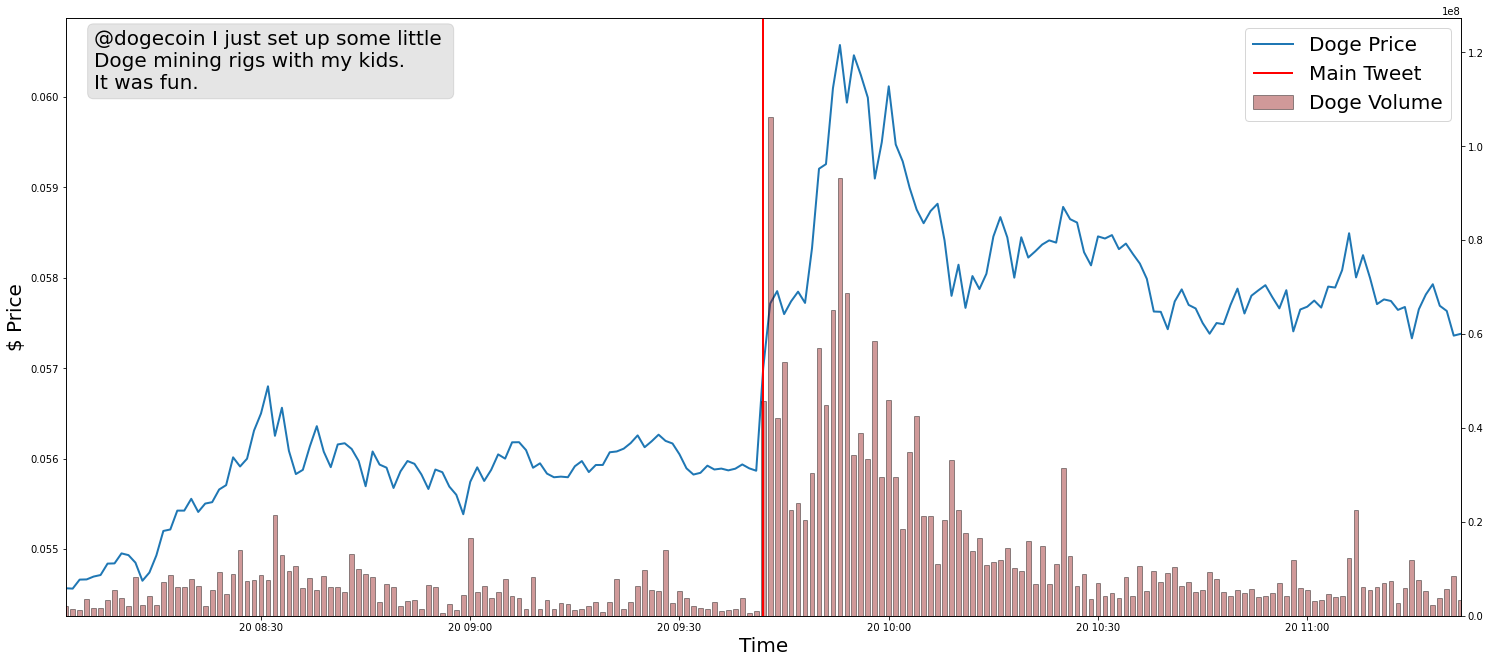

C:\Users\ckopp\AppData\Local\Temp\ipykernel_7308\396780057.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doge_sliced['CAR'] = doge_sliced['Close']/base_value


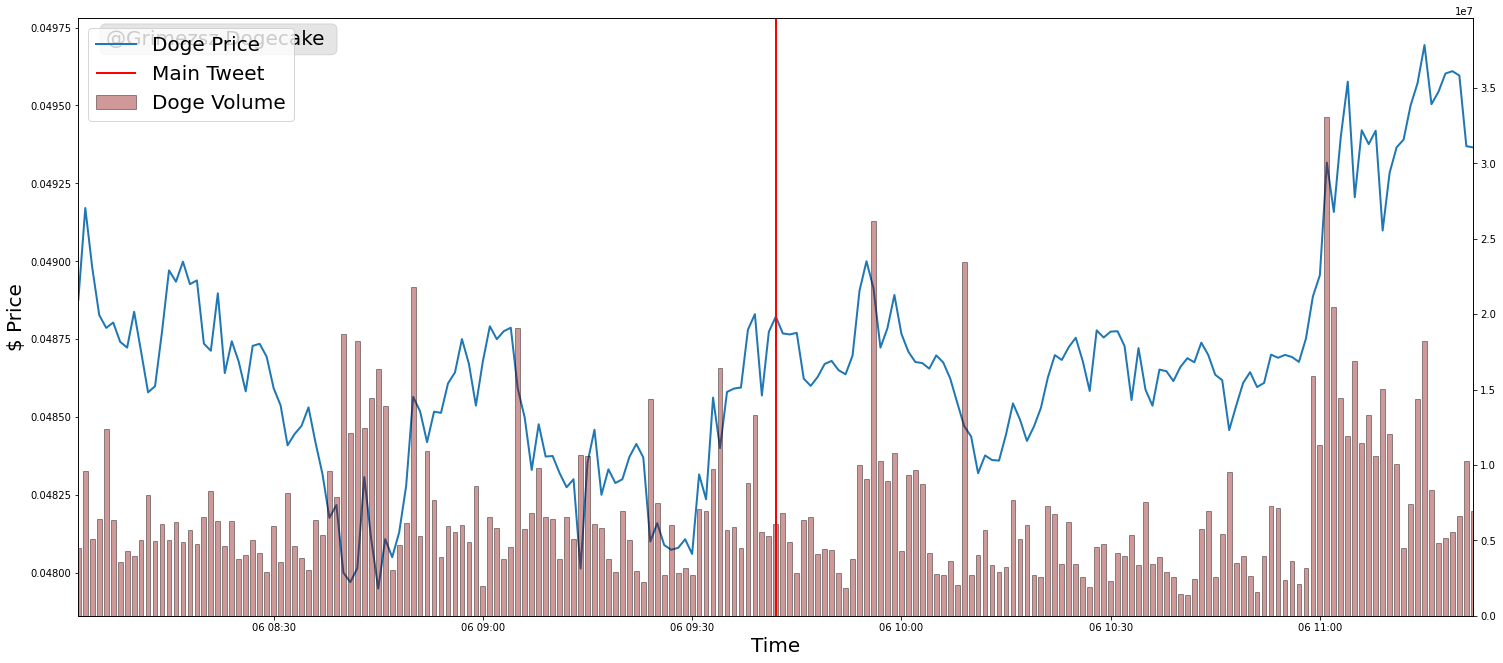

C:\Users\ckopp\AppData\Local\Temp\ipykernel_7308\396780057.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doge_sliced['CAR'] = doge_sliced['Close']/base_value


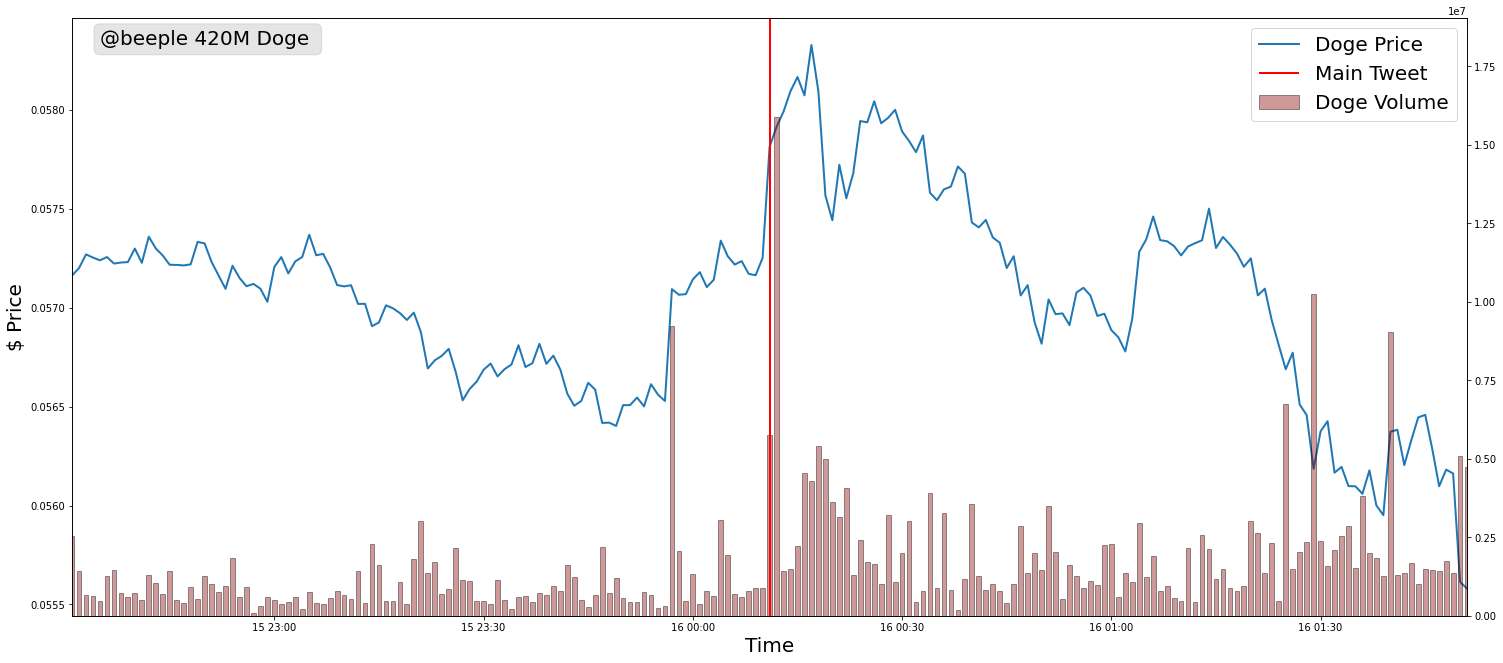

C:\Users\ckopp\AppData\Local\Temp\ipykernel_7308\396780057.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doge_sliced['CAR'] = doge_sliced['Close']/base_value


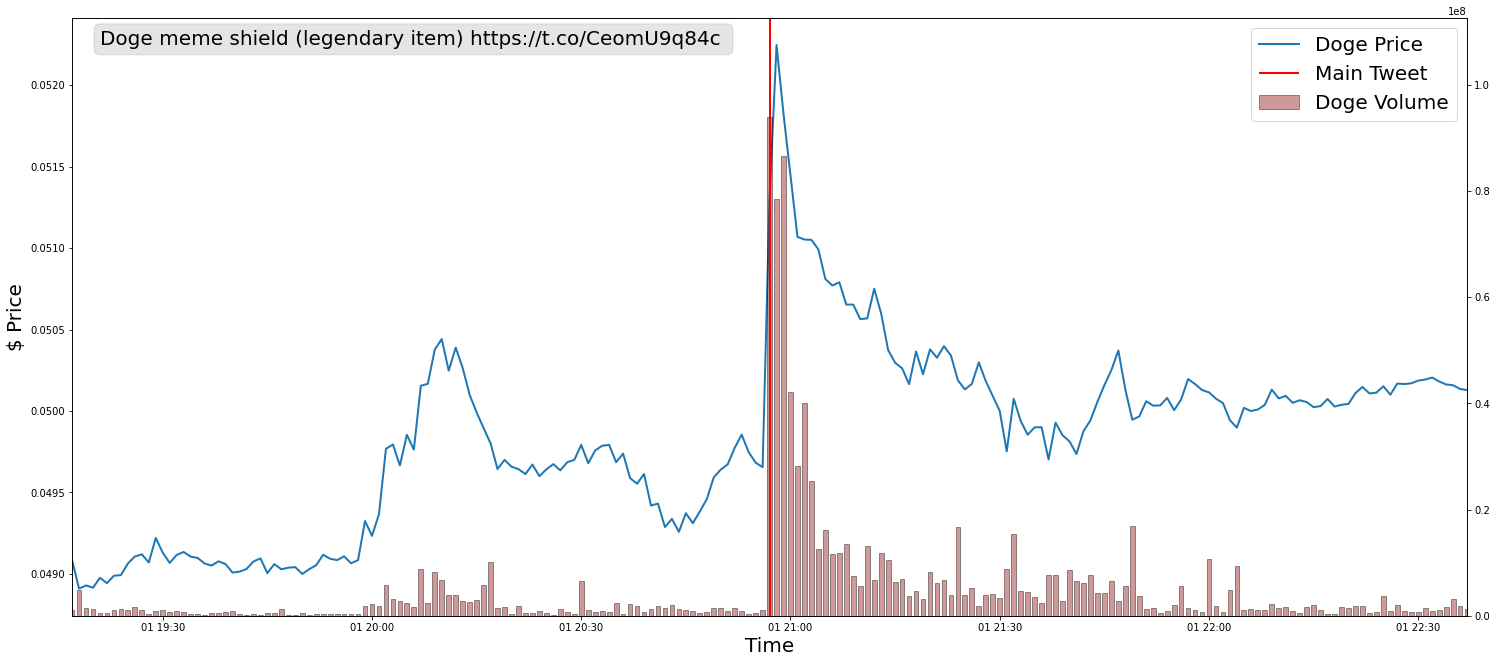

C:\Users\ckopp\AppData\Local\Temp\ipykernel_7308\396780057.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doge_sliced['CAR'] = doge_sliced['Close']/base_value


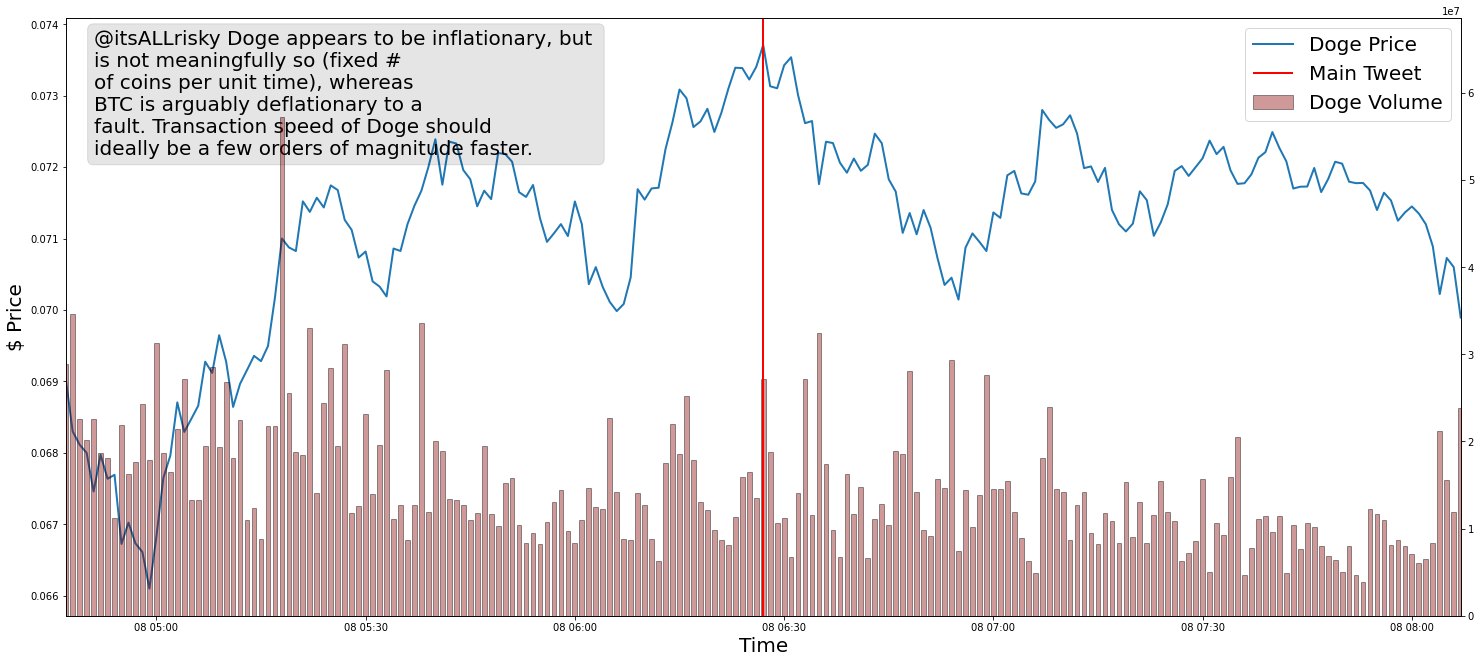

C:\Users\ckopp\AppData\Local\Temp\ipykernel_7308\396780057.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doge_sliced['CAR'] = doge_sliced['Close']/base_value


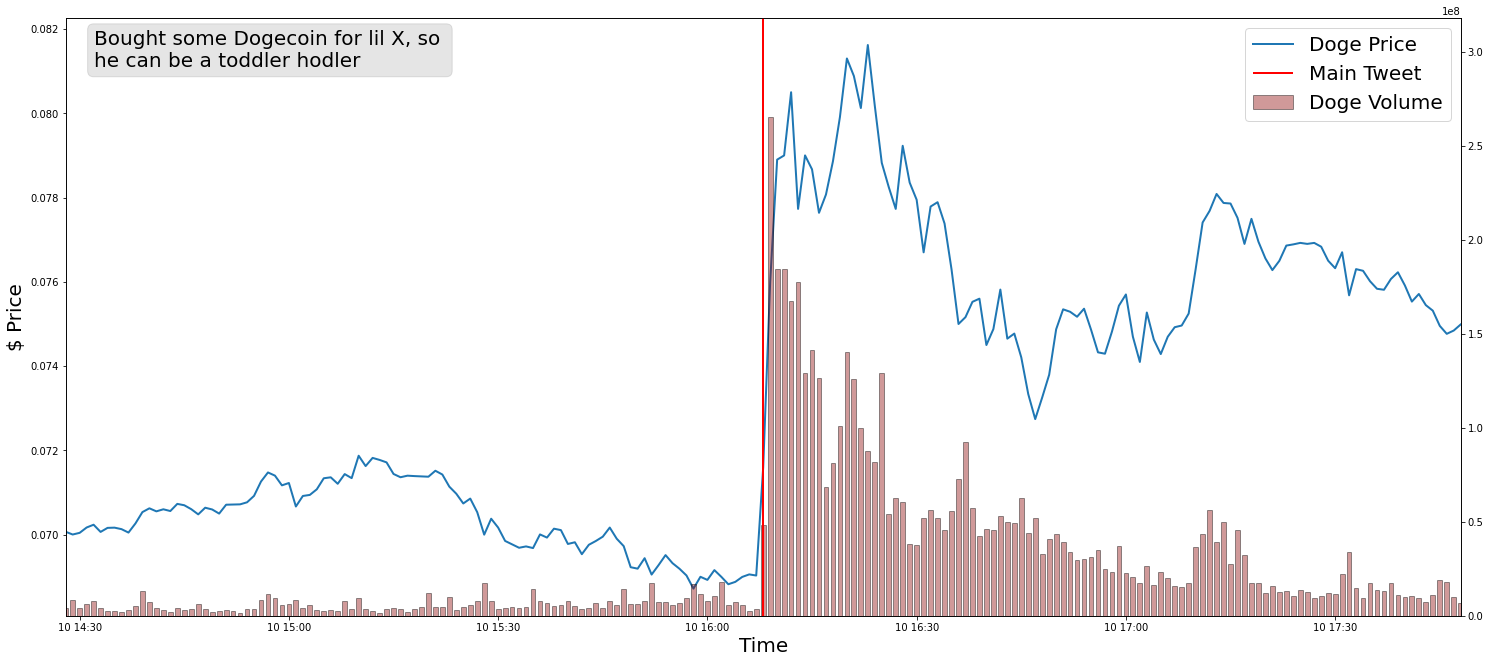

C:\Users\ckopp\AppData\Local\Temp\ipykernel_7308\396780057.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doge_sliced['CAR'] = doge_sliced['Close']/base_value


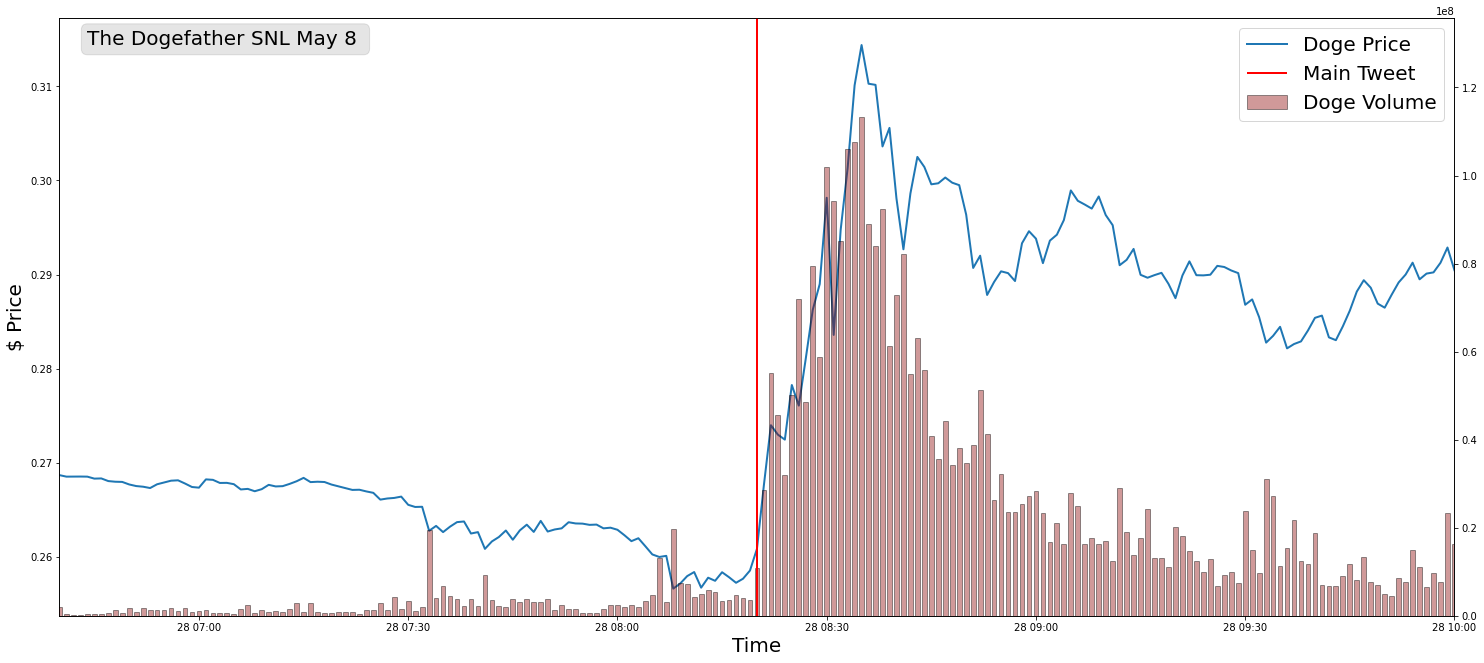

C:\Users\ckopp\AppData\Local\Temp\ipykernel_7308\396780057.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doge_sliced['CAR'] = doge_sliced['Close']/base_value


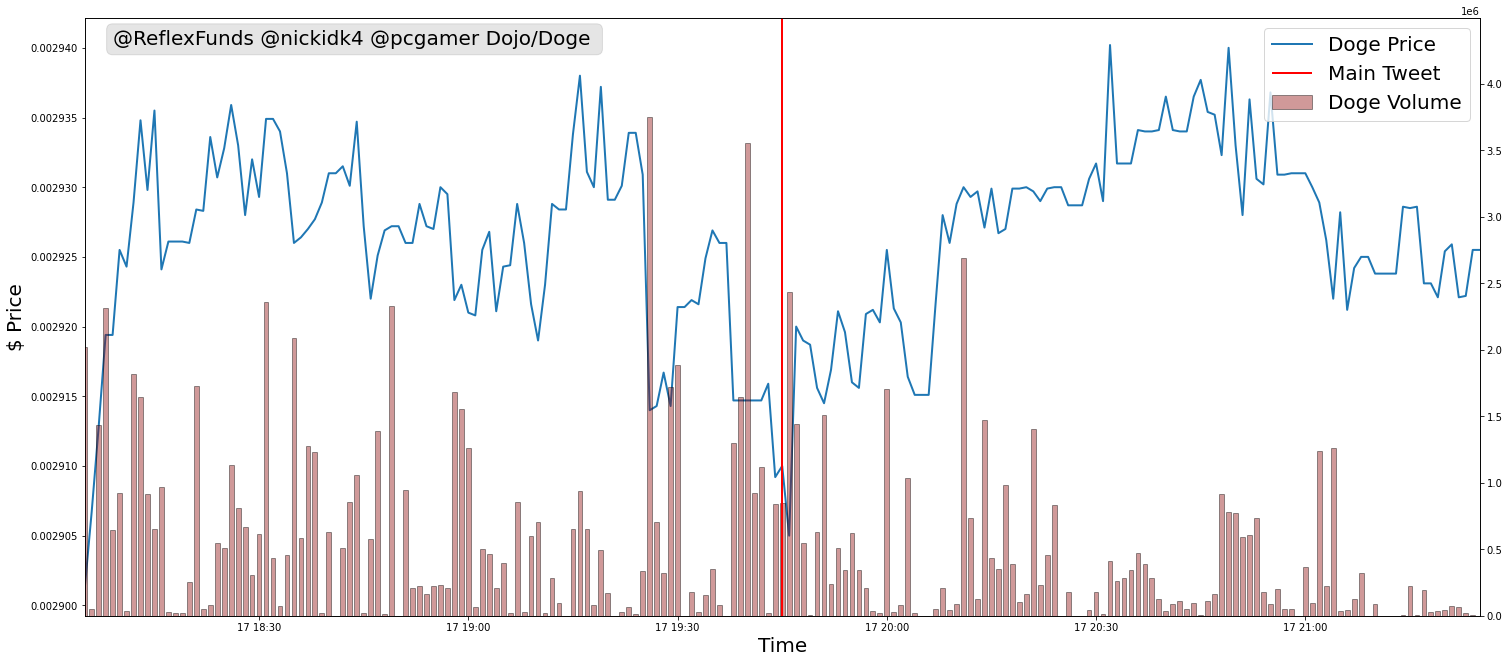

C:\Users\ckopp\AppData\Local\Temp\ipykernel_7308\396780057.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doge_sliced['CAR'] = doge_sliced['Close']/base_value


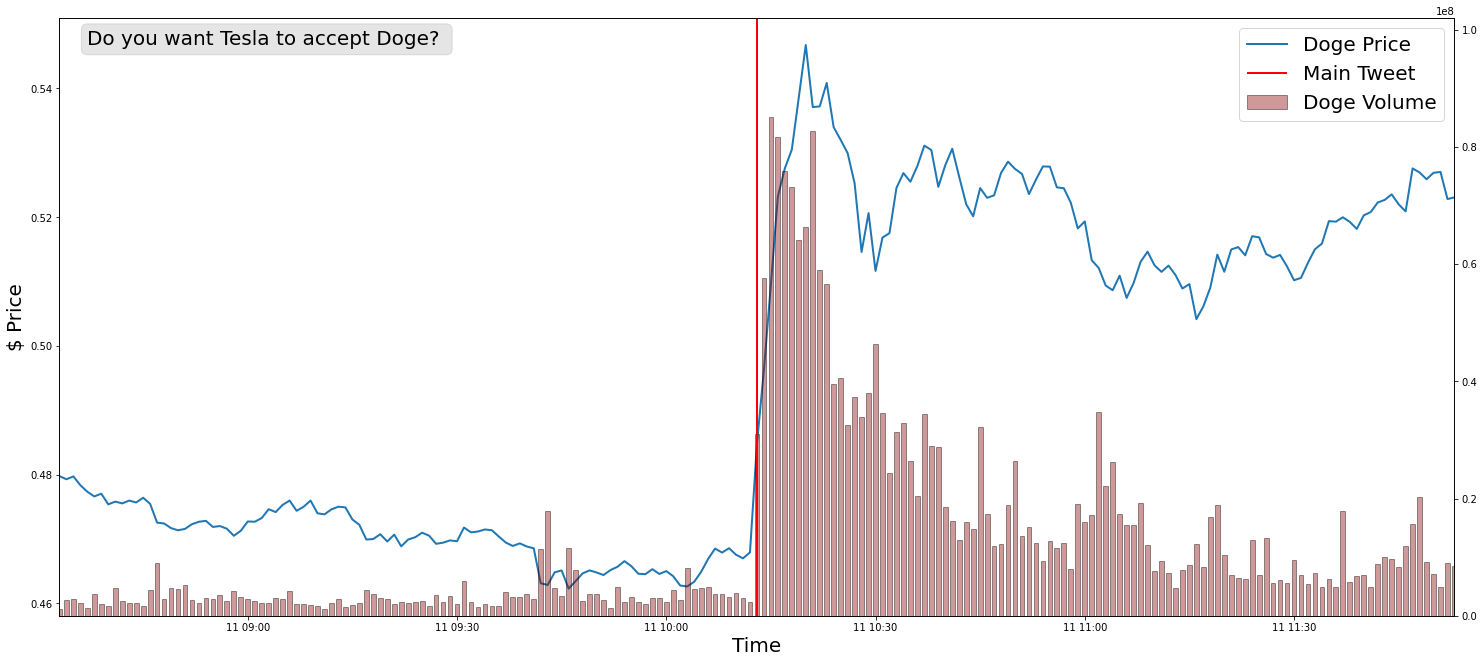

C:\Users\ckopp\AppData\Local\Temp\ipykernel_7308\396780057.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doge_sliced['CAR'] = doge_sliced['Close']/base_value


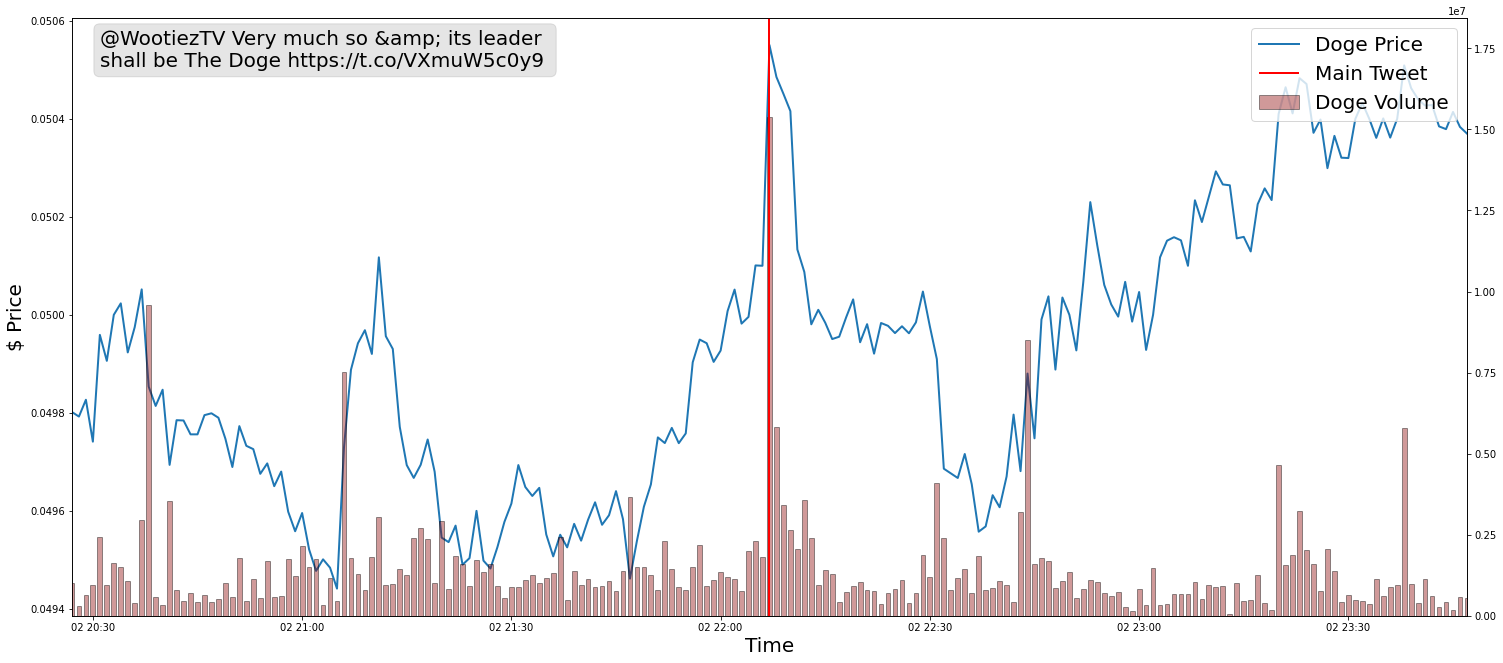

C:\Users\ckopp\AppData\Local\Temp\ipykernel_7308\396780057.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doge_sliced['CAR'] = doge_sliced['Close']/base_value


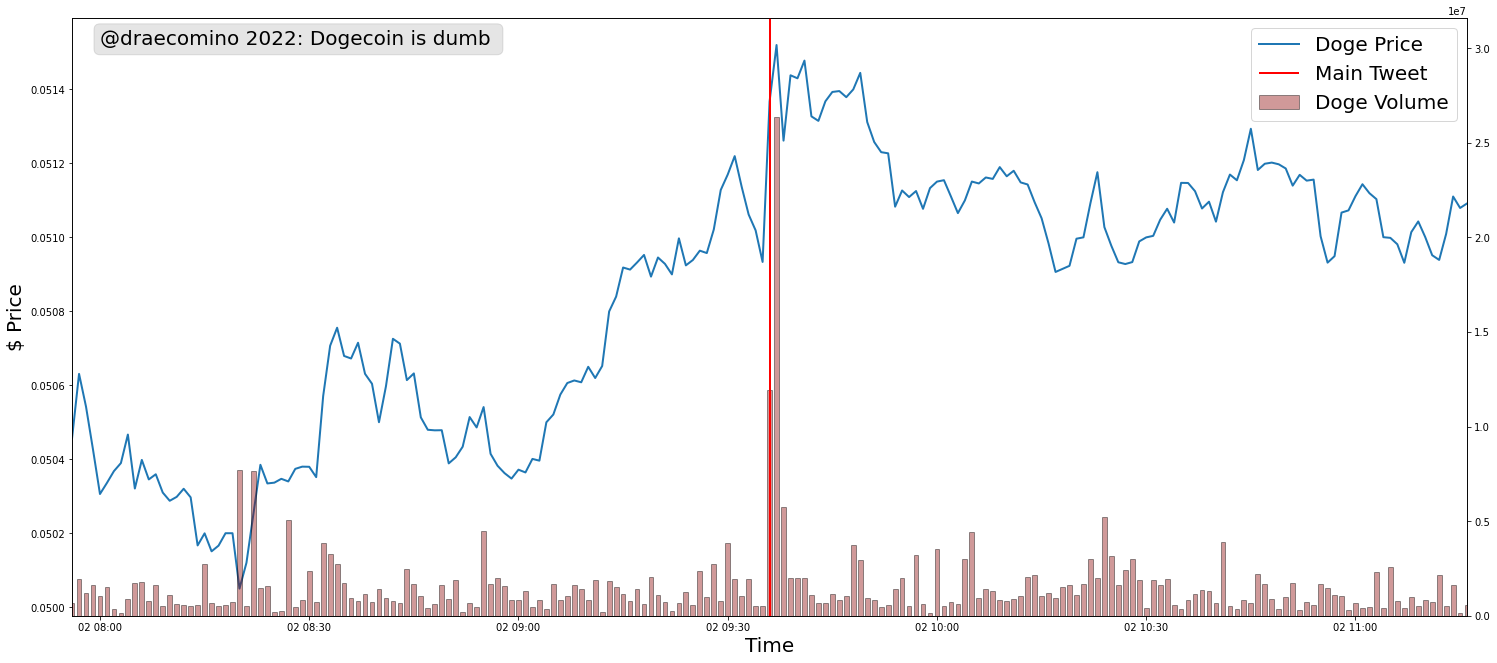

C:\Users\ckopp\AppData\Local\Temp\ipykernel_7308\396780057.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doge_sliced['CAR'] = doge_sliced['Close']/base_value


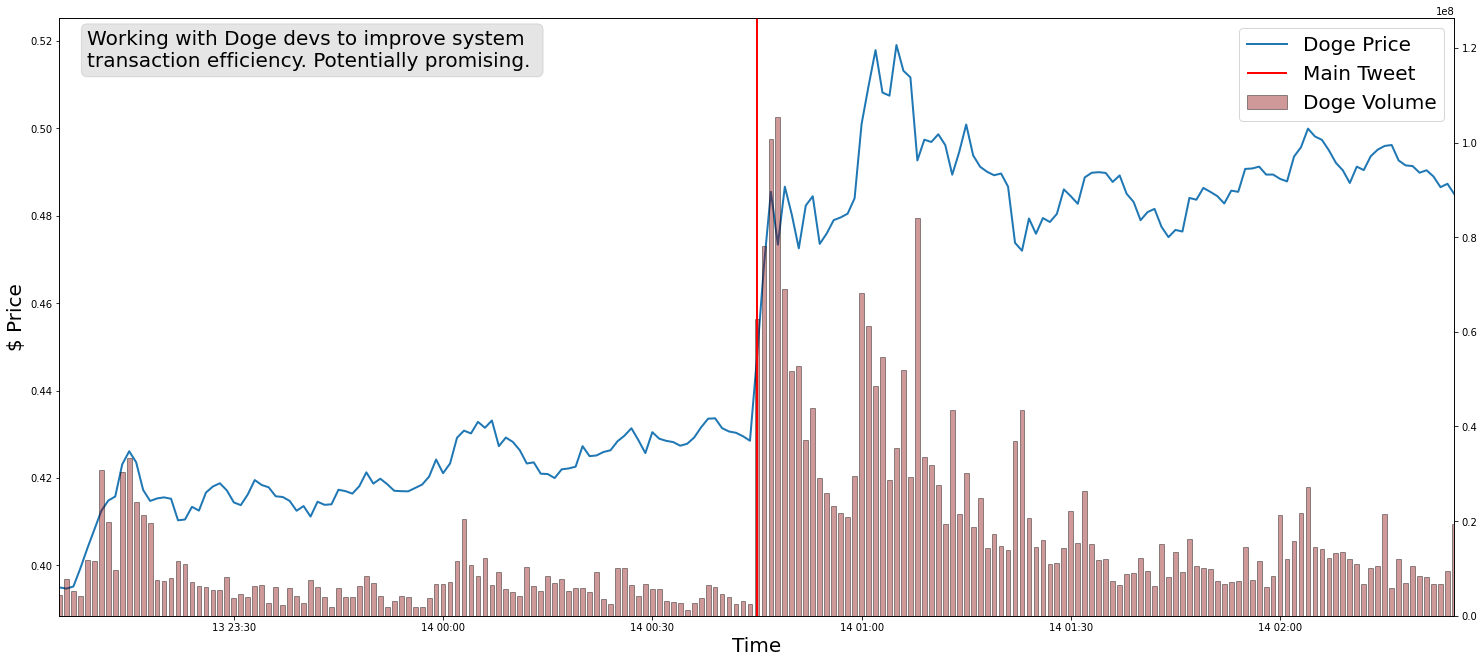

C:\Users\ckopp\AppData\Local\Temp\ipykernel_7308\396780057.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doge_sliced['CAR'] = doge_sliced['Close']/base_value


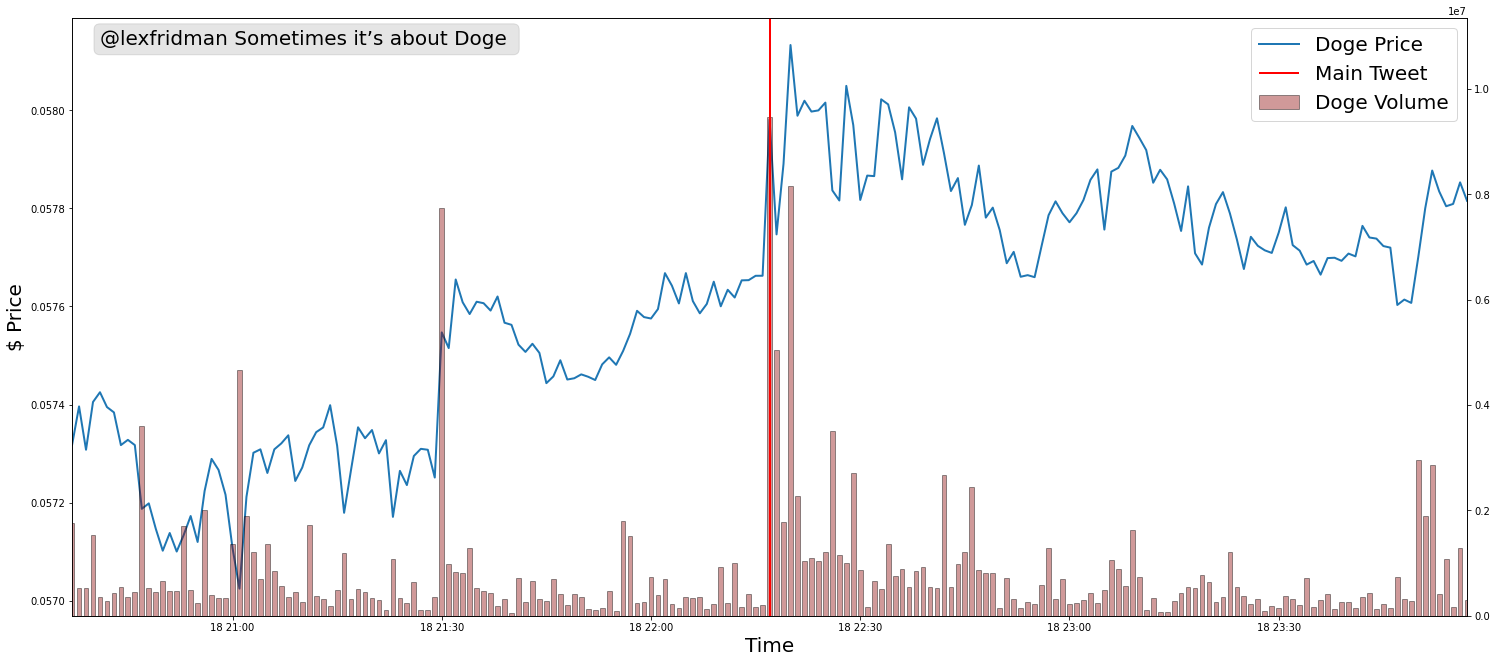

C:\Users\ckopp\AppData\Local\Temp\ipykernel_7308\396780057.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doge_sliced['CAR'] = doge_sliced['Close']/base_value


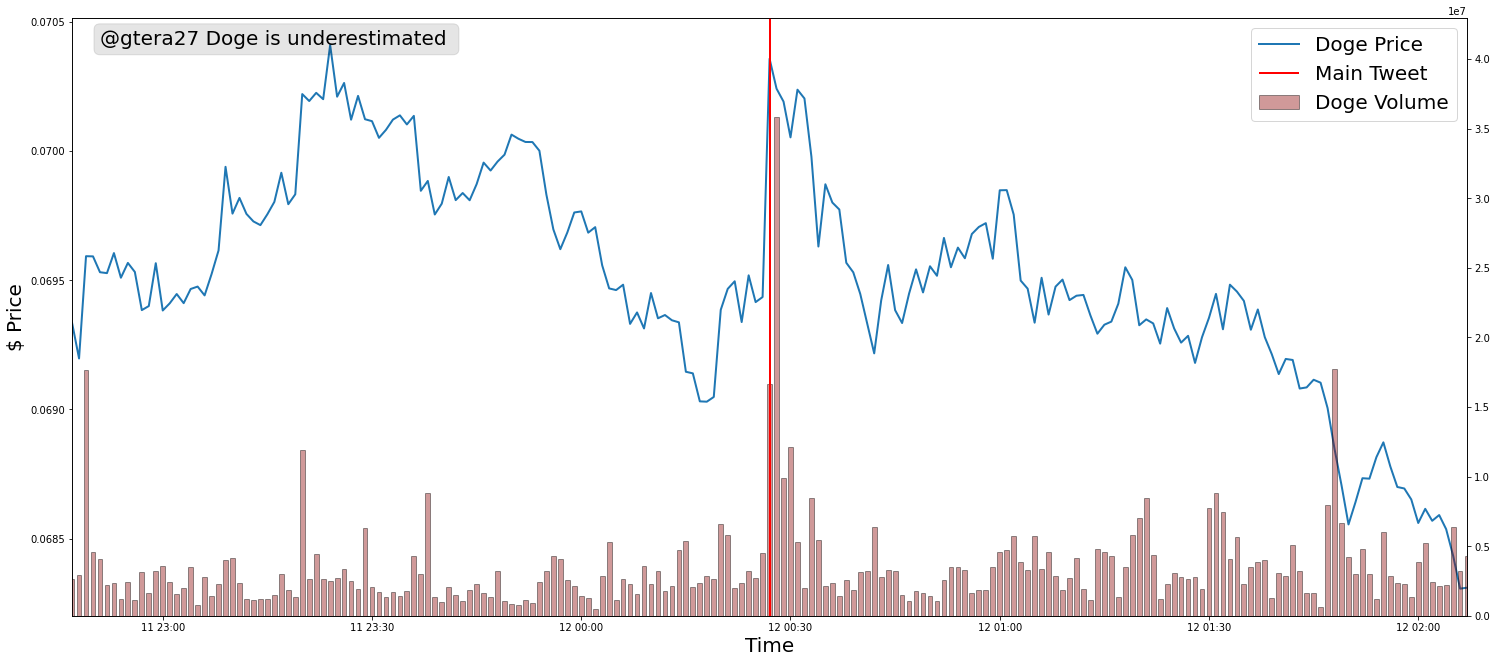

C:\Users\ckopp\AppData\Local\Temp\ipykernel_7308\396780057.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doge_sliced['CAR'] = doge_sliced['Close']/base_value


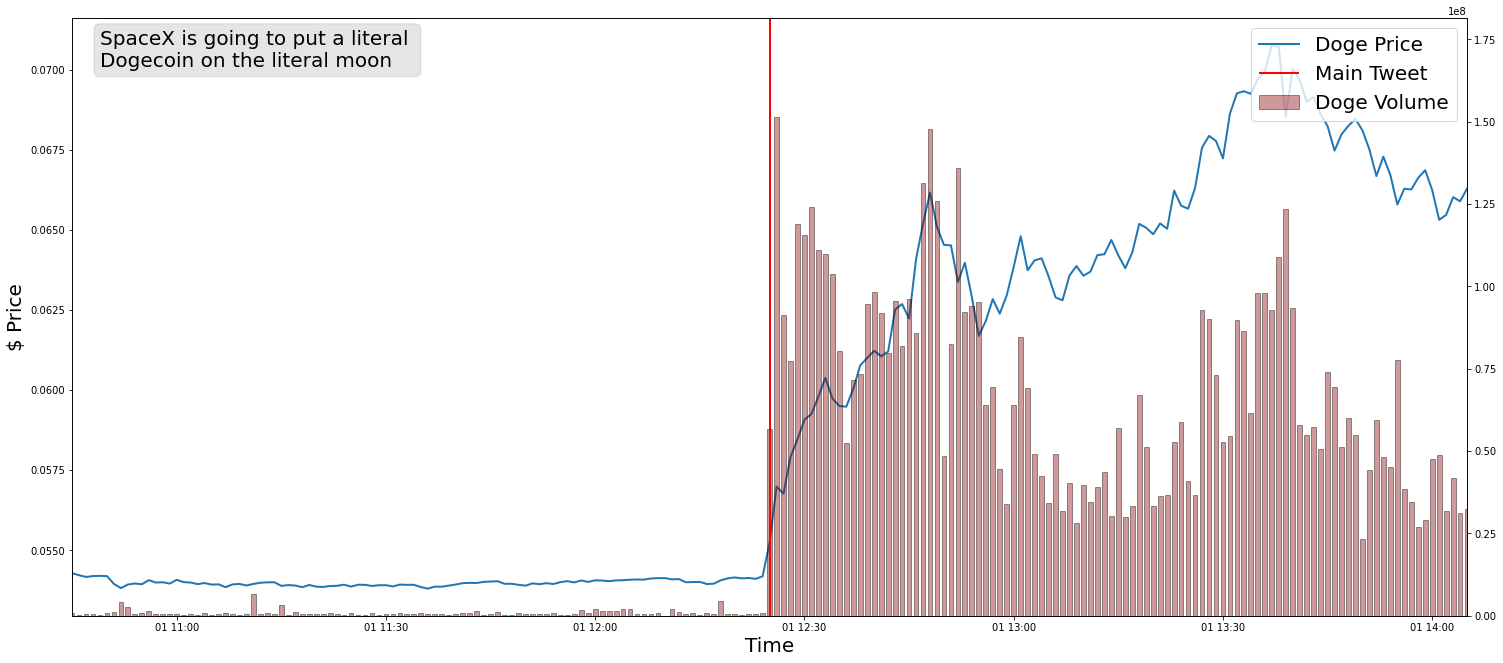

C:\Users\ckopp\AppData\Local\Temp\ipykernel_7308\396780057.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doge_sliced['CAR'] = doge_sliced['Close']/base_value


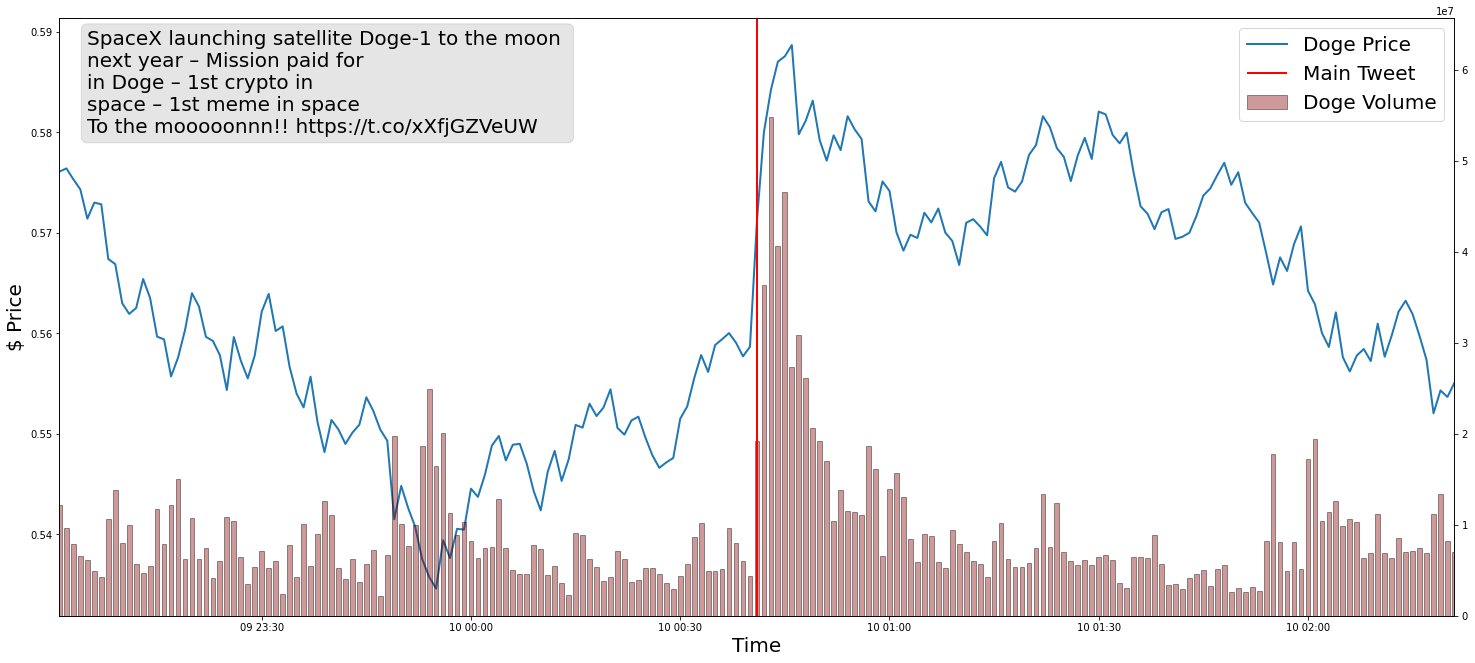

C:\Users\ckopp\AppData\Local\Temp\ipykernel_7308\396780057.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doge_sliced['CAR'] = doge_sliced['Close']/base_value


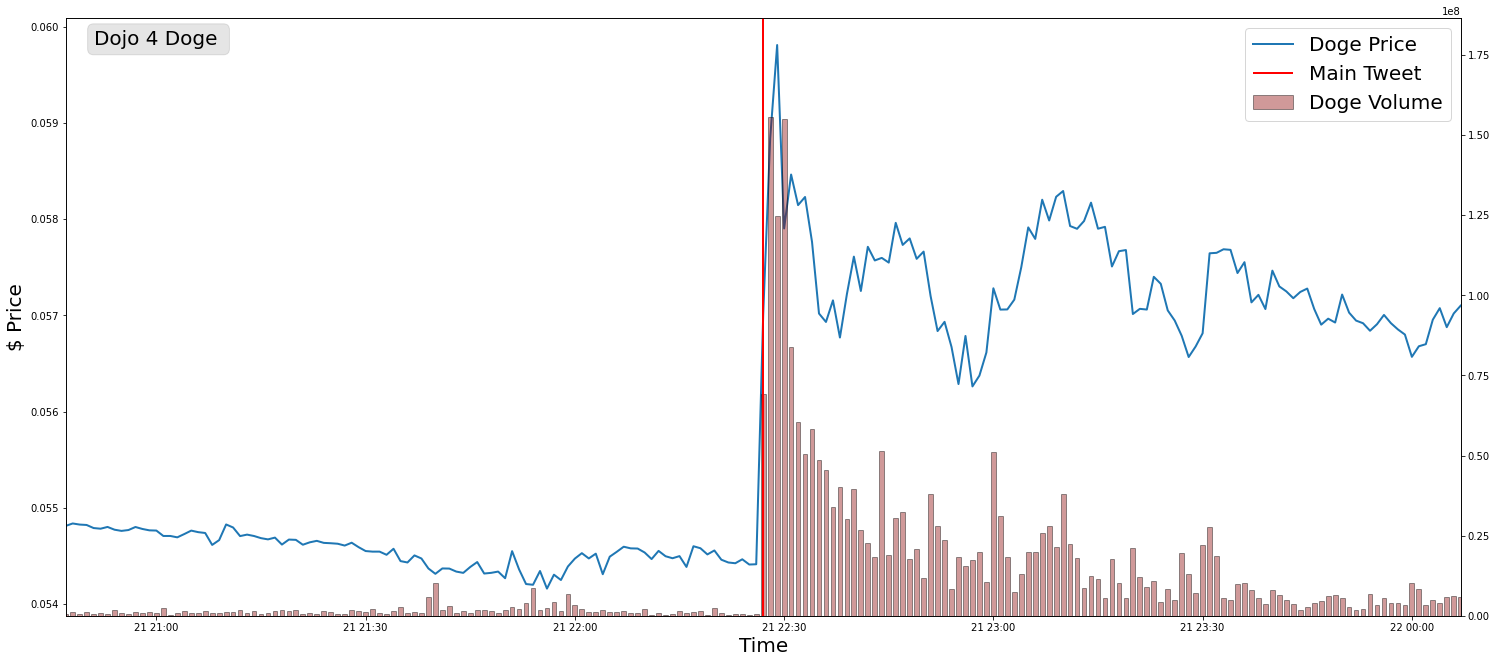

C:\Users\ckopp\AppData\Local\Temp\ipykernel_7308\396780057.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doge_sliced['CAR'] = doge_sliced['Close']/base_value
C:\Users\ckopp\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 127926 (\N{MULTIPLE MUSICAL NOTES}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


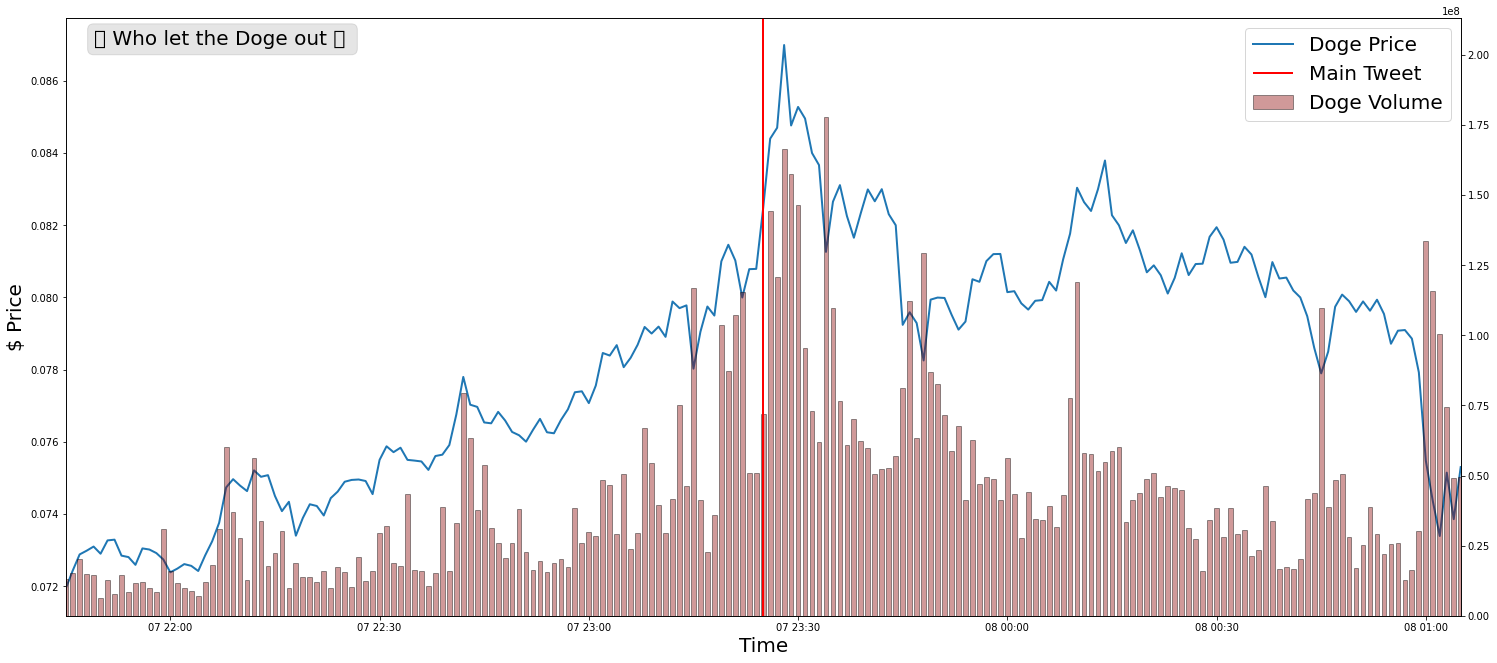

C:\Users\ckopp\AppData\Local\Temp\ipykernel_7308\396780057.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doge_sliced['CAR'] = doge_sliced['Close']/base_value


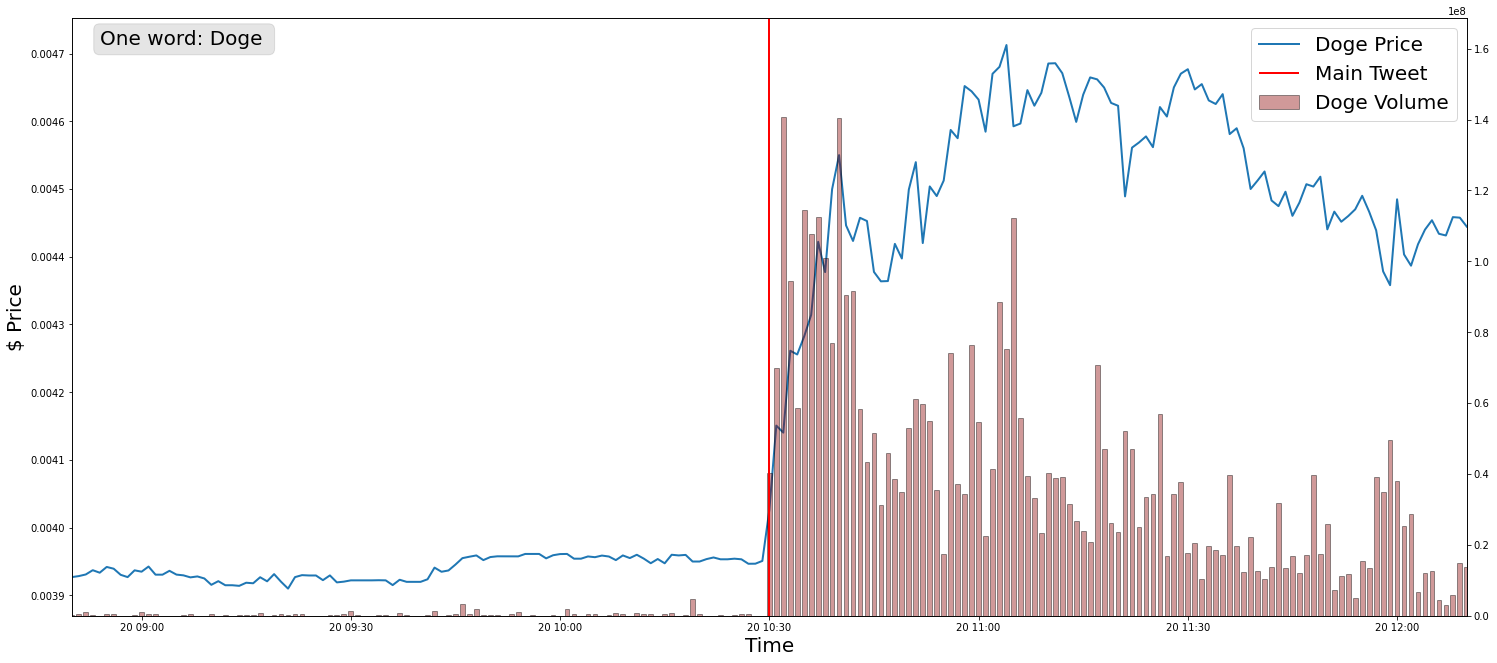

In [ ]:
df['Date'] = df['timestamp'].apply(lambda x: dt.fromtimestamp(x))

for _, tweet in df_tweets_relevant.iterrows():
    timestamp = tweet['timestamp']
    doge_sliced = df[(df['timestamp'] >= timestamp-100*60) & (df['timestamp'] <= timestamp+100*60)]
    tweets_sliced = df_tweets[(df_tweets['timestamp'] >= timestamp-100*60) & (df_tweets['timestamp'] <= timestamp+100*60)]

    base_value = doge_sliced.iloc[0, 4]
    doge_sliced['CAR'] = doge_sliced['Close']/base_value

    fig = plt.figure(1, figsize = (25, 11))
    ax = fig.add_subplot(111)
    ax.plot(doge_sliced['Date'], doge_sliced['Close'], lw=2, label="Doge Price")

    ax2 = ax.twinx()
    ax2.bar(doge_sliced['Date'], doge_sliced['Volume'], label="Doge Volume", color='darkred', alpha=0.4, width=1/(35*60), edgecolor='black')
    ax2.vlines(dt.fromtimestamp(timestamp), label='Main Tweet', ymin=0, ymax=doge_sliced['Volume'].max()*1.2, colors='red', lw=2) 

    if len(tweets_sliced) > 1:
        ax2.vlines([dt.fromtimestamp(i) for i in tweets_sliced['timestamp'] if i != timestamp], label='Other Tweets', ymin=0, ymax=doge_sliced['Volume'].max()*1.2, colors='orange', lw=2) 
   
    ax2.set_ylim(0, doge_sliced['Volume'].max()*1.2)
    ax.set_xlim(min(doge_sliced['Date']), max(doge_sliced['Date']))
    ax.set_xlabel("Time", size=20)
    ax.set_ylabel("$ Price", size=20)

    t = [i + ' ' for i in tweet['Text'].split()]
    for i in range(7, len(t), 7):
        t.insert(i, '\n')
    anno = ''.join(t)

    ax.text(0.02, 0.98, anno, transform=ax.transAxes, bbox={'boxstyle':'round', 'facecolor':'black', 'alpha':0.1}, fontsize = 20, va='top')
    

    li, la = ax.get_legend_handles_labels()
    li2, la2 = ax2.get_legend_handles_labels()
    plt.legend(li+li2, la+la2, loc='best', fontsize = 20)
    # plt.legend(loc='best', fontsize=20)

    if timestamp == 1620945900:
        plt.savefig('Price_Vol_Übersicht.pdf')
        
    plt.show()



    #print(tweet['Text'])

***Volume***

C:\Users\ckopp\AppData\Local\Temp\ipykernel_7308\1871894440.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doge_sliced["log_vol"] = np.log(doge_sliced['Quote Asset Volume']+1)
C:\Users\ckopp\AppData\Local\Temp\ipykernel_7308\1871894440.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doge_sliced['cum_log_vol'] = np.cumsum(doge_sliced['log_vol'])
C:\Users\ckopp\AppData\Local\Temp\ipykernel_7308\1871894440.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

Expected Volume =  11.471705437595174
T[0; 1] =  8.626923930643425
T[0; 5] =  13.95087223689145
T[0; 10] =  21.04672578011501
T[0; 30] =  30.912162646844514
T[0; 60] =  21.417661175167723
T[0; 120] =  20.937709510023115


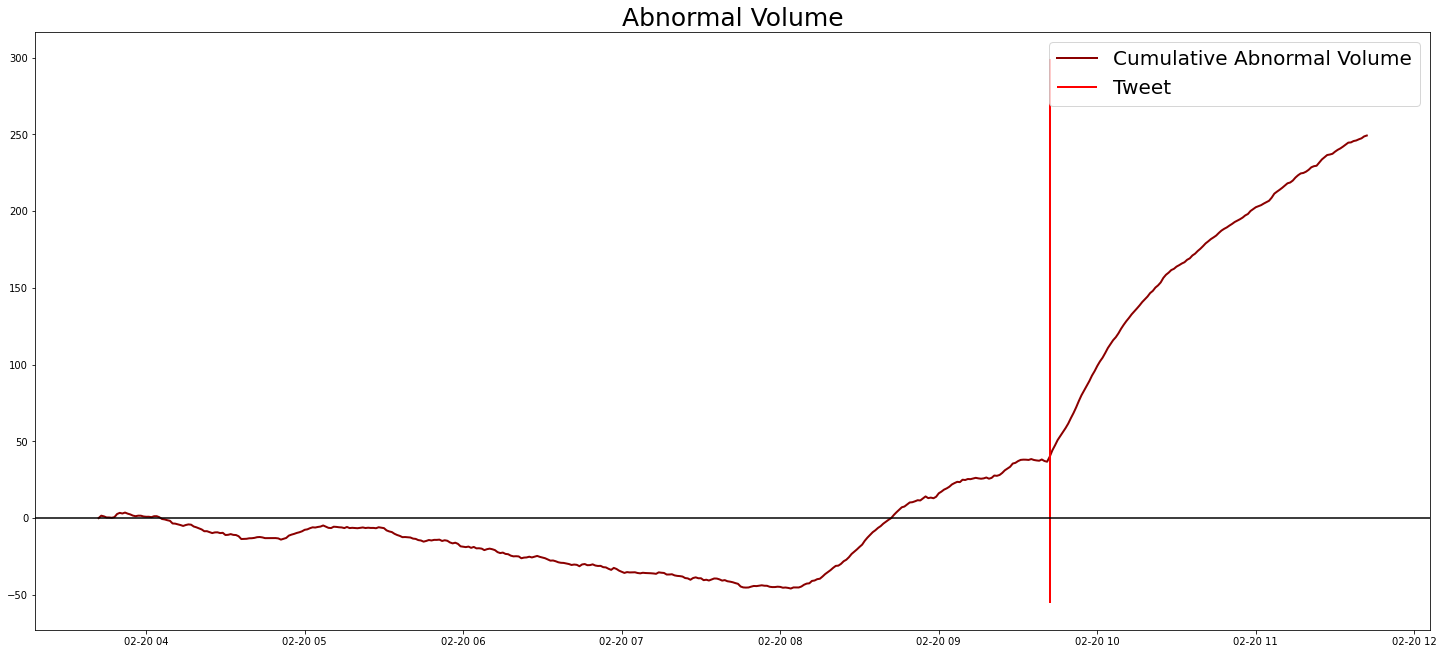

C:\Users\ckopp\AppData\Local\Temp\ipykernel_7308\1871894440.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doge_sliced["log_vol"] = np.log(doge_sliced['Quote Asset Volume']+1)
C:\Users\ckopp\AppData\Local\Temp\ipykernel_7308\1871894440.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doge_sliced['cum_log_vol'] = np.cumsum(doge_sliced['log_vol'])
C:\Users\ckopp\AppData\Local\Temp\ipykernel_7308\1871894440.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

Expected Volume =  12.75399376264293
T[0; 1] =  -1.6333117310498095
T[0; 5] =  -2.046983239610331
T[0; 10] =  -3.93813506133753
T[0; 30] =  -2.179492804766328
T[0; 60] =  -6.068647293221964
T[0; 120] =  -1.5359607045662287


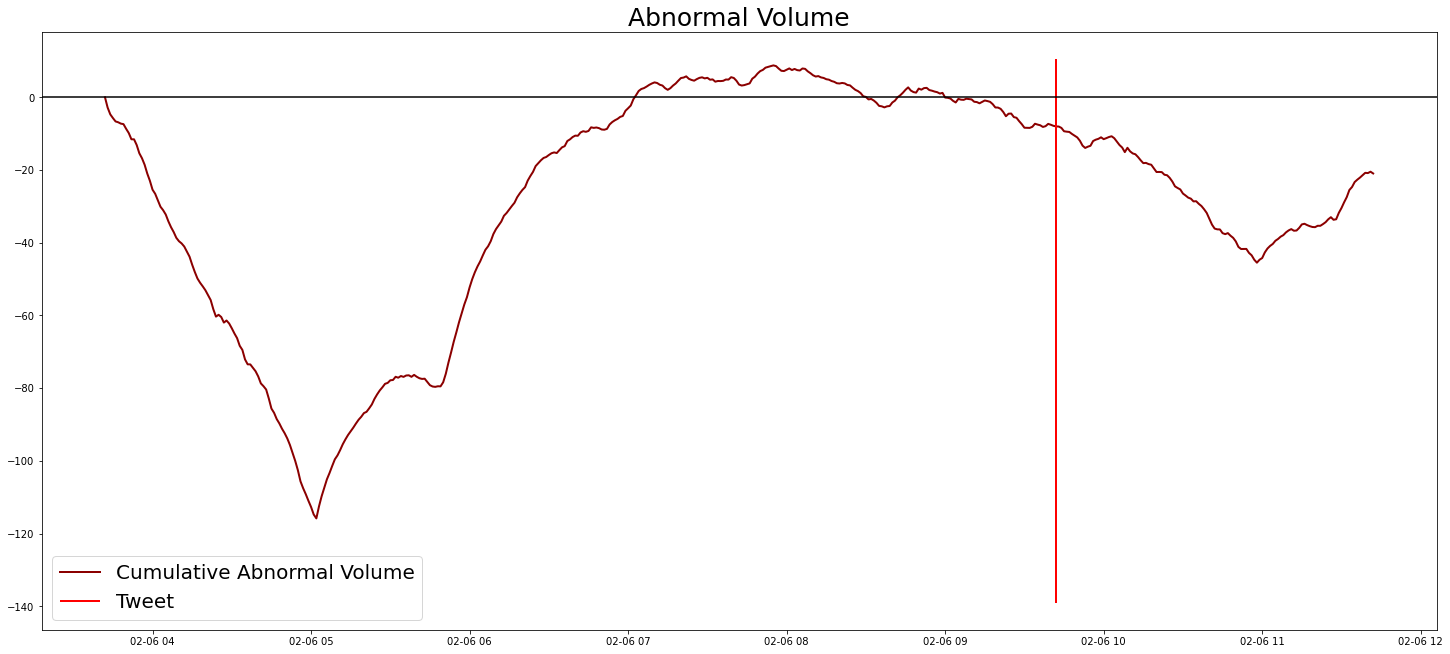

C:\Users\ckopp\AppData\Local\Temp\ipykernel_7308\1871894440.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doge_sliced["log_vol"] = np.log(doge_sliced['Quote Asset Volume']+1)
C:\Users\ckopp\AppData\Local\Temp\ipykernel_7308\1871894440.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doge_sliced['cum_log_vol'] = np.cumsum(doge_sliced['log_vol'])
C:\Users\ckopp\AppData\Local\Temp\ipykernel_7308\1871894440.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

Expected Volume =  10.83391652383195
T[0; 1] =  4.662901568963254
T[0; 5] =  3.665705295271669
T[0; 10] =  7.1805087849191525
T[0; 30] =  5.485523602845455
T[0; 60] =  5.878741929221326
T[0; 120] =  10.96842401011265


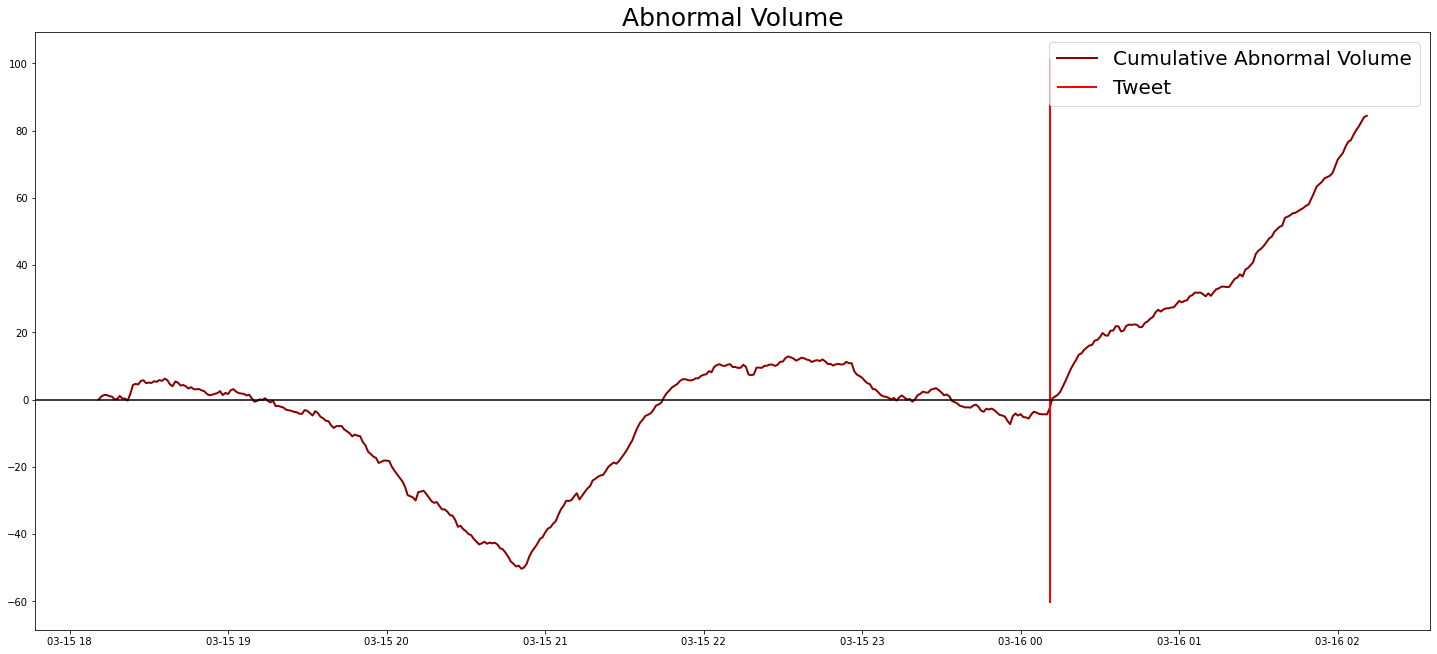

C:\Users\ckopp\AppData\Local\Temp\ipykernel_7308\1871894440.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doge_sliced["log_vol"] = np.log(doge_sliced['Quote Asset Volume']+1)
C:\Users\ckopp\AppData\Local\Temp\ipykernel_7308\1871894440.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doge_sliced['cum_log_vol'] = np.cumsum(doge_sliced['log_vol'])
C:\Users\ckopp\AppData\Local\Temp\ipykernel_7308\1871894440.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

Expected Volume =  10.985928194070267
T[0; 1] =  52.3232676229821
T[0; 5] =  19.012473503735407
T[0; 10] =  13.429757704702524
T[0; 30] =  12.597788135396442
T[0; 60] =  13.166387676404973
T[0; 120] =  9.88738920140787


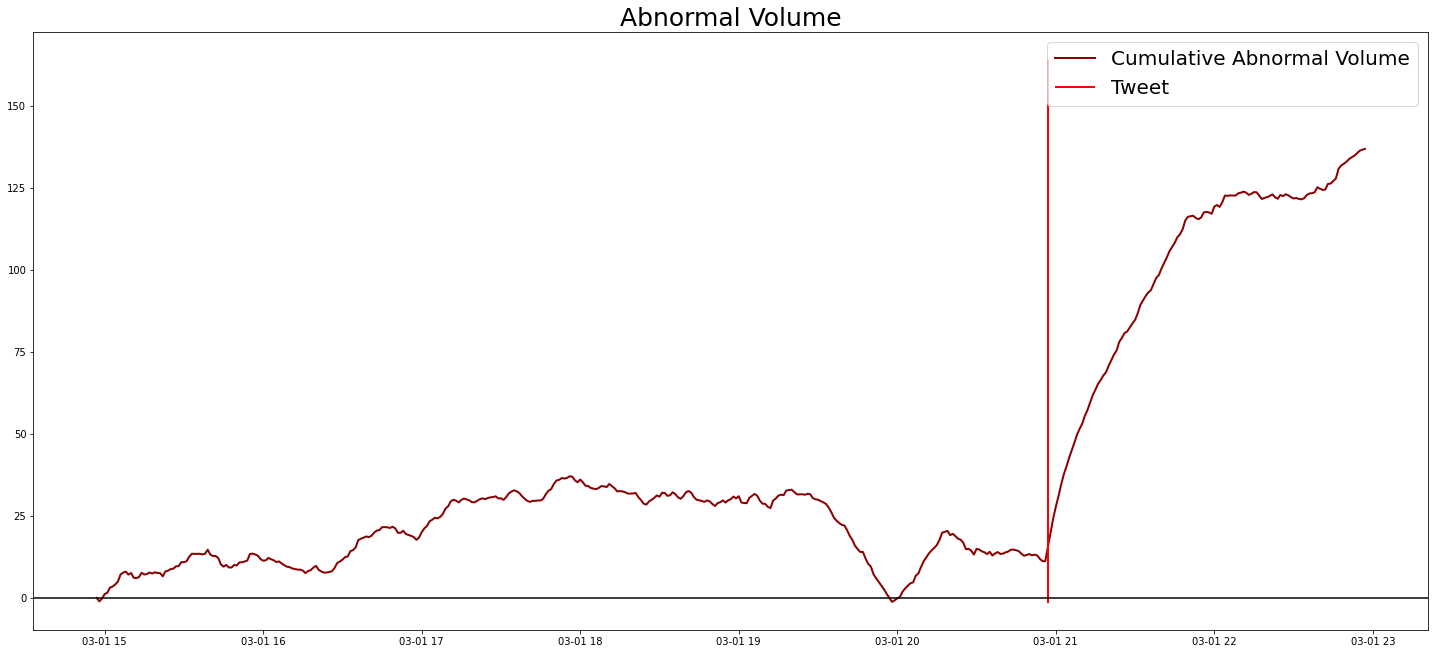

C:\Users\ckopp\AppData\Local\Temp\ipykernel_7308\1871894440.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doge_sliced["log_vol"] = np.log(doge_sliced['Quote Asset Volume']+1)
C:\Users\ckopp\AppData\Local\Temp\ipykernel_7308\1871894440.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doge_sliced['cum_log_vol'] = np.cumsum(doge_sliced['log_vol'])
C:\Users\ckopp\AppData\Local\Temp\ipykernel_7308\1871894440.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

Expected Volume =  14.450668252465013
T[0; 1] =  -0.6773650325230022
T[0; 5] =  -3.2902820348897484
T[0; 10] =  -3.5659837152077296
T[0; 30] =  -8.200875300402695
T[0; 60] =  -13.745218941672427
T[0; 120] =  -19.298812730381293


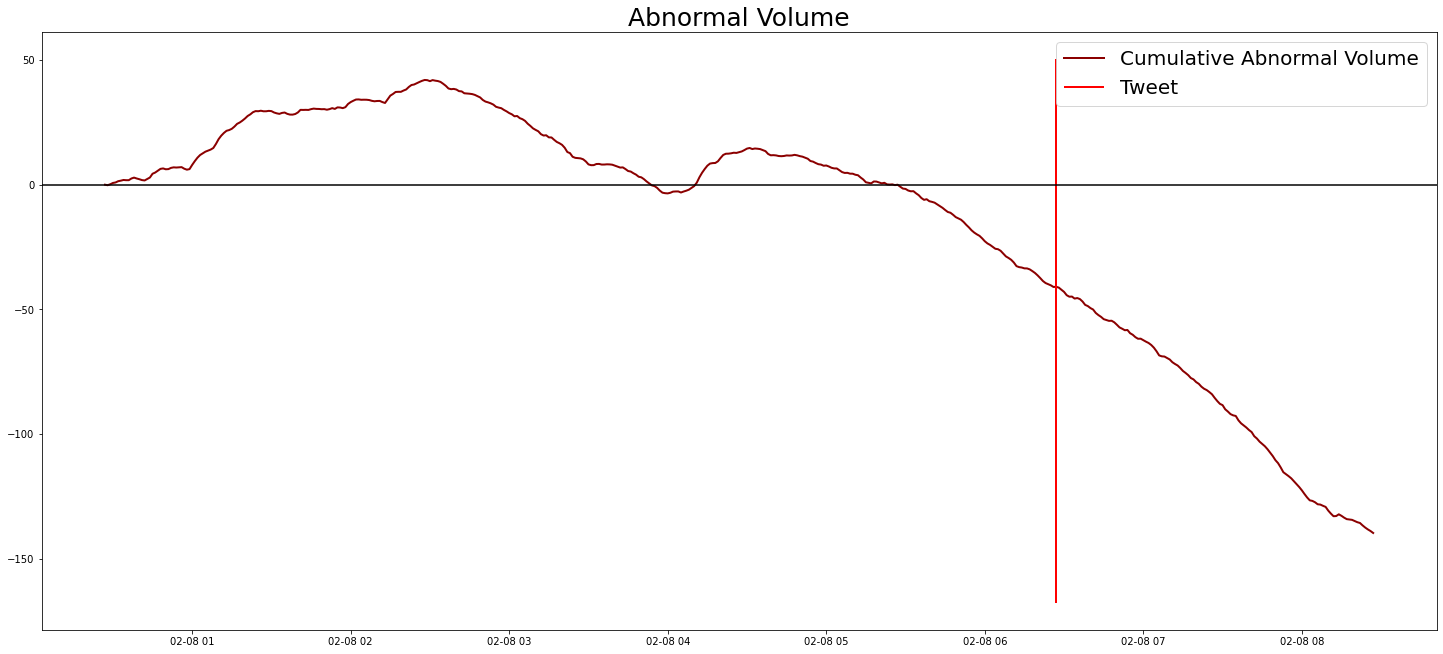

C:\Users\ckopp\AppData\Local\Temp\ipykernel_7308\1871894440.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doge_sliced["log_vol"] = np.log(doge_sliced['Quote Asset Volume']+1)
C:\Users\ckopp\AppData\Local\Temp\ipykernel_7308\1871894440.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doge_sliced['cum_log_vol'] = np.cumsum(doge_sliced['log_vol'])
C:\Users\ckopp\AppData\Local\Temp\ipykernel_7308\1871894440.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

Expected Volume =  12.79698246625773
T[0; 1] =  3.564016477589421
T[0; 5] =  13.750703576068268
T[0; 10] =  21.23004519603626
T[0; 30] =  30.793607934816244
T[0; 60] =  26.7495439600863
T[0; 120] =  22.86638491866343


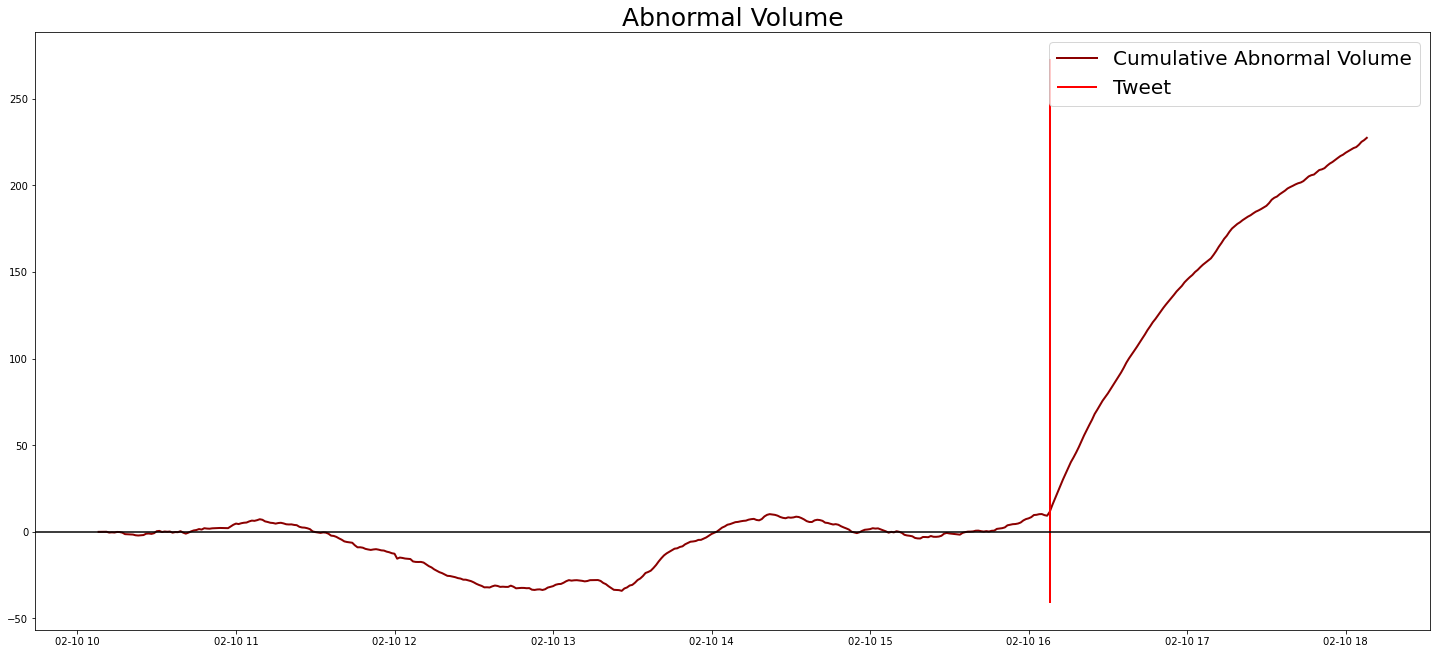

C:\Users\ckopp\AppData\Local\Temp\ipykernel_7308\1871894440.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doge_sliced["log_vol"] = np.log(doge_sliced['Quote Asset Volume']+1)
C:\Users\ckopp\AppData\Local\Temp\ipykernel_7308\1871894440.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doge_sliced['cum_log_vol'] = np.cumsum(doge_sliced['log_vol'])
C:\Users\ckopp\AppData\Local\Temp\ipykernel_7308\1871894440.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

Expected Volume =  12.700123136117513
T[0; 1] =  5.283681927036017
T[0; 5] =  12.912610611007198
T[0; 10] =  18.952894191149472
T[0; 30] =  40.70433785079176
T[0; 60] =  40.0545022480394
T[0; 120] =  34.746451721203016


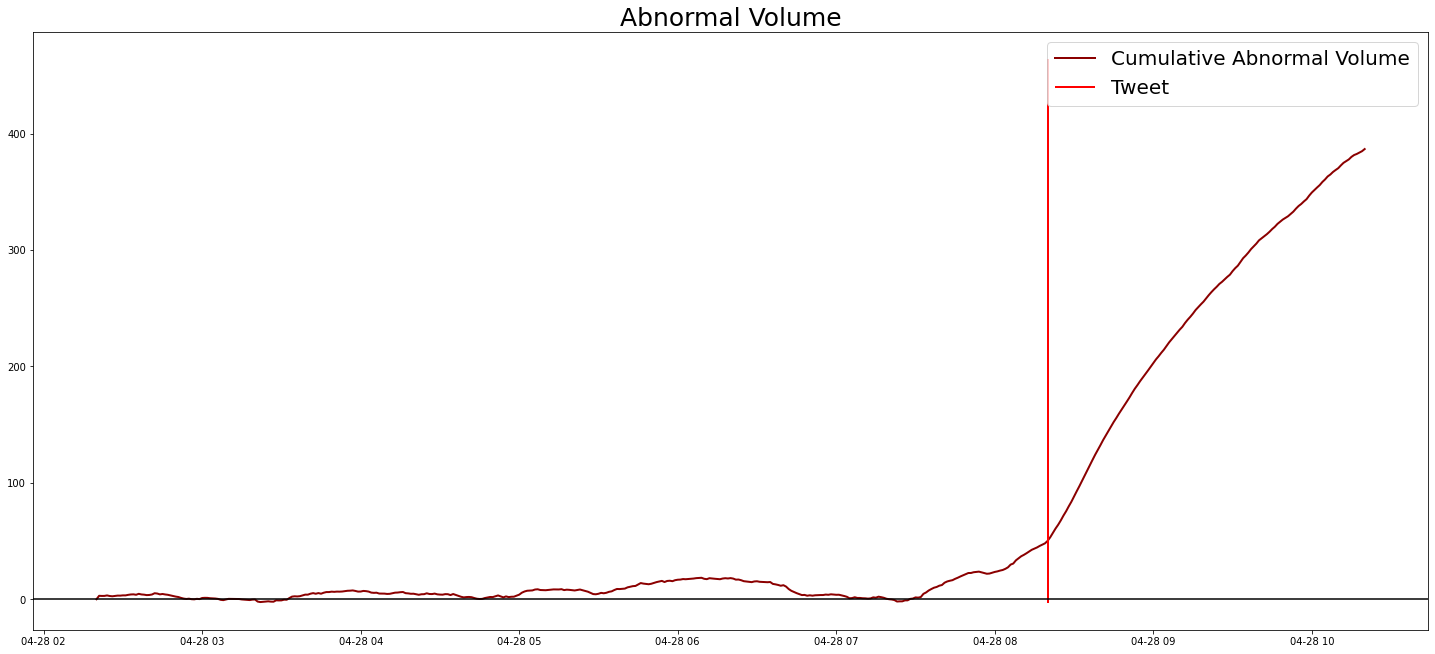

C:\Users\ckopp\AppData\Local\Temp\ipykernel_7308\1871894440.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doge_sliced["log_vol"] = np.log(doge_sliced['Quote Asset Volume']+1)
C:\Users\ckopp\AppData\Local\Temp\ipykernel_7308\1871894440.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doge_sliced['cum_log_vol'] = np.cumsum(doge_sliced['log_vol'])
C:\Users\ckopp\AppData\Local\Temp\ipykernel_7308\1871894440.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

Expected Volume =  6.678765738630577
T[0; 1] =  3.1400473461187794
T[0; 5] =  0.5323666489647155
T[0; 10] =  1.1542550385281185
T[0; 30] =  -1.1741822706718088
T[0; 60] =  -2.630928491212129
T[0; 120] =  -4.371460093775853


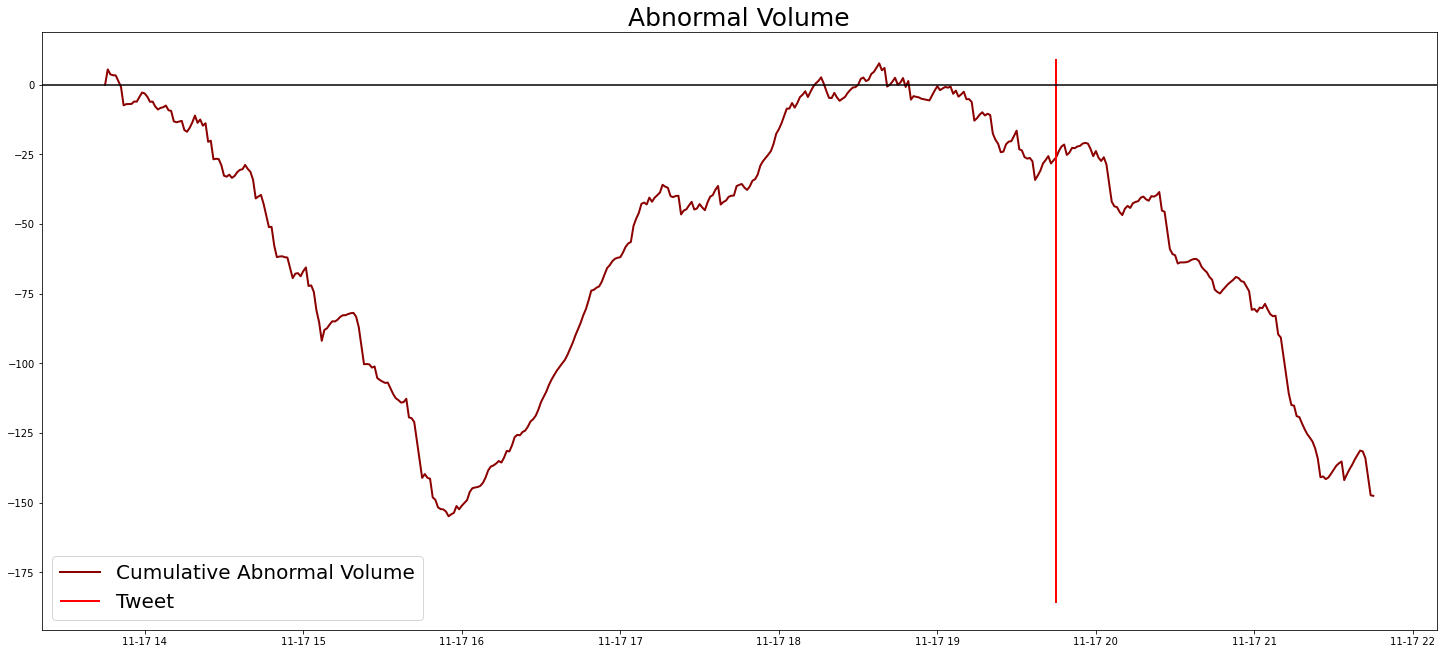

C:\Users\ckopp\AppData\Local\Temp\ipykernel_7308\1871894440.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doge_sliced["log_vol"] = np.log(doge_sliced['Quote Asset Volume']+1)
C:\Users\ckopp\AppData\Local\Temp\ipykernel_7308\1871894440.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doge_sliced['cum_log_vol'] = np.cumsum(doge_sliced['log_vol'])
C:\Users\ckopp\AppData\Local\Temp\ipykernel_7308\1871894440.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

Expected Volume =  14.3232646111382
T[0; 1] =  7.797130127885086
T[0; 5] =  17.633891591313745
T[0; 10] =  32.215956756447696
T[0; 30] =  26.50830725462545
T[0; 60] =  22.71714182570315
T[0; 120] =  19.690805727786024


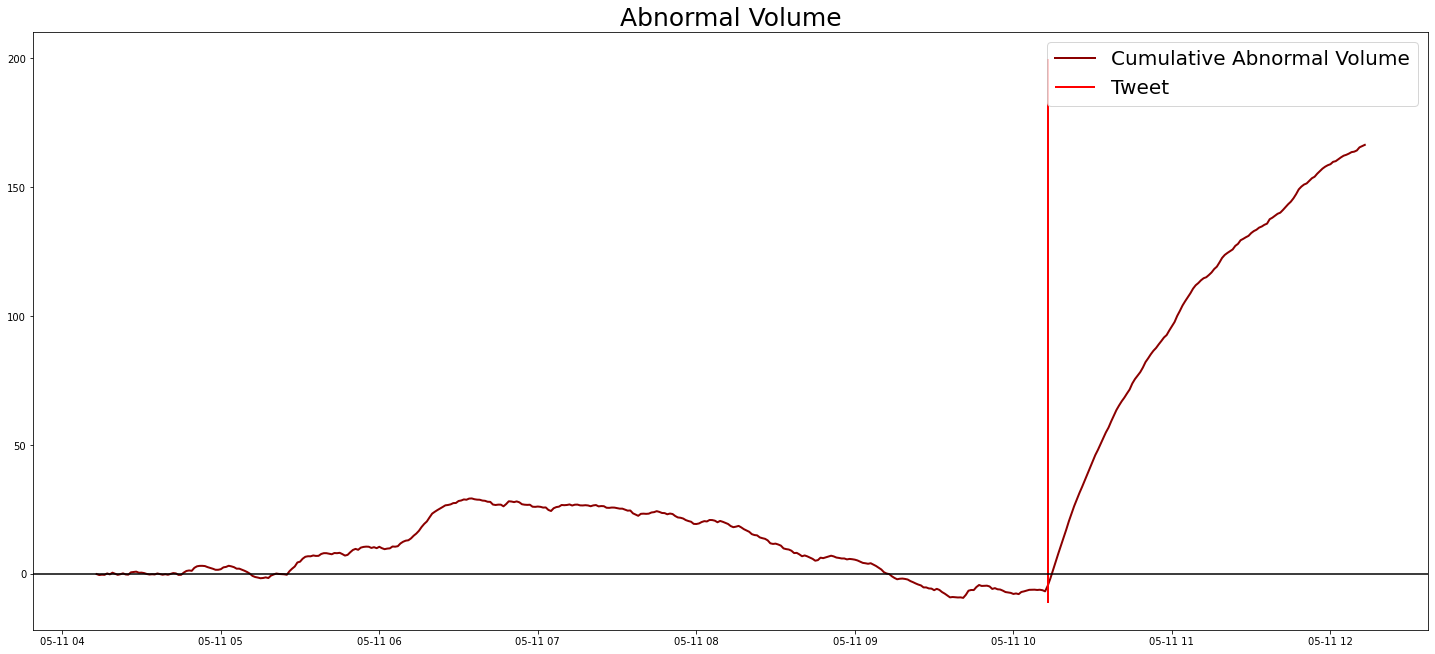

C:\Users\ckopp\AppData\Local\Temp\ipykernel_7308\1871894440.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doge_sliced["log_vol"] = np.log(doge_sliced['Quote Asset Volume']+1)
C:\Users\ckopp\AppData\Local\Temp\ipykernel_7308\1871894440.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doge_sliced['cum_log_vol'] = np.cumsum(doge_sliced['log_vol'])
C:\Users\ckopp\AppData\Local\Temp\ipykernel_7308\1871894440.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

Expected Volume =  11.042470012721772
T[0; 1] =  4.206767689500681
T[0; 5] =  4.194736110596668
T[0; 10] =  2.1555883152879964
T[0; 30] =  0.5259581896987582
T[0; 60] =  -1.4939846029110184
T[0; 120] =  -4.357603503605197


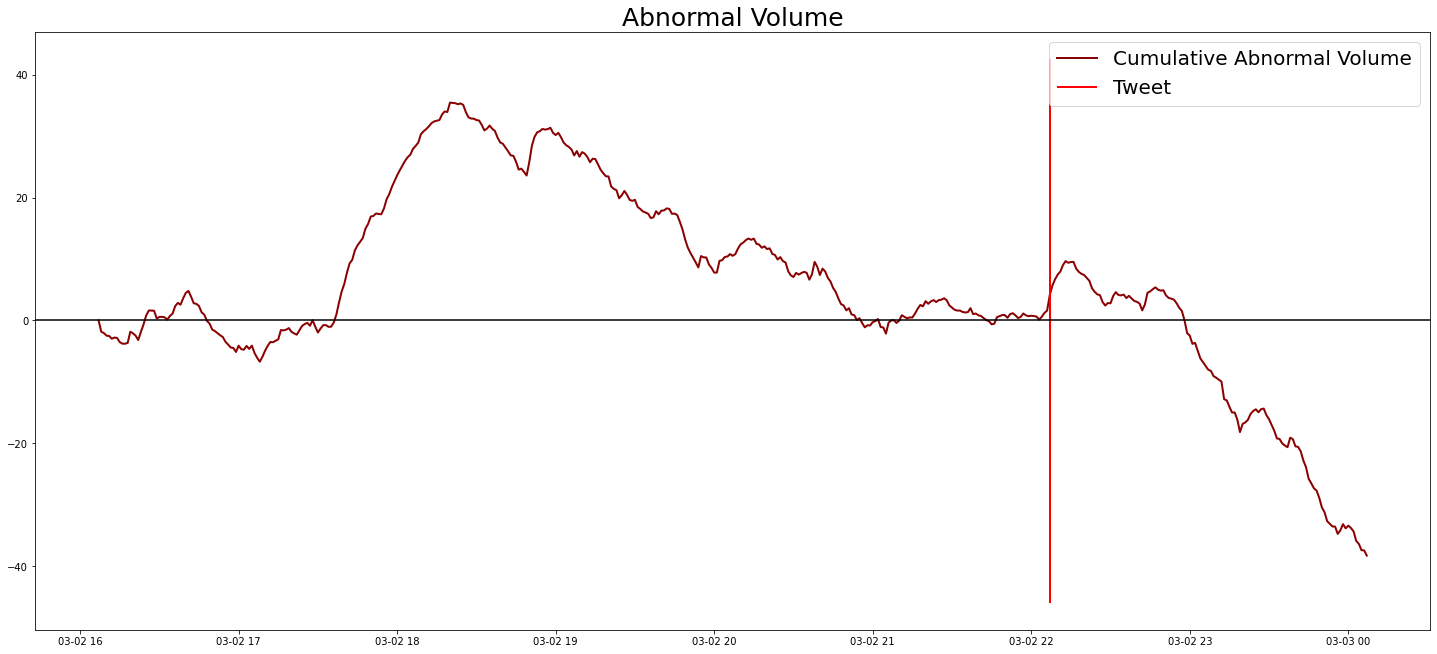

C:\Users\ckopp\AppData\Local\Temp\ipykernel_7308\1871894440.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doge_sliced["log_vol"] = np.log(doge_sliced['Quote Asset Volume']+1)
C:\Users\ckopp\AppData\Local\Temp\ipykernel_7308\1871894440.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doge_sliced['cum_log_vol'] = np.cumsum(doge_sliced['log_vol'])
C:\Users\ckopp\AppData\Local\Temp\ipykernel_7308\1871894440.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

Expected Volume =  10.994636801173764
T[0; 1] =  6.846369735308932
T[0; 5] =  3.214000234648008
T[0; 10] =  1.8064470116073958
T[0; 30] =  1.1406277391161797
T[0; 60] =  1.8439952416660017
T[0; 120] =  -1.6412072637538409


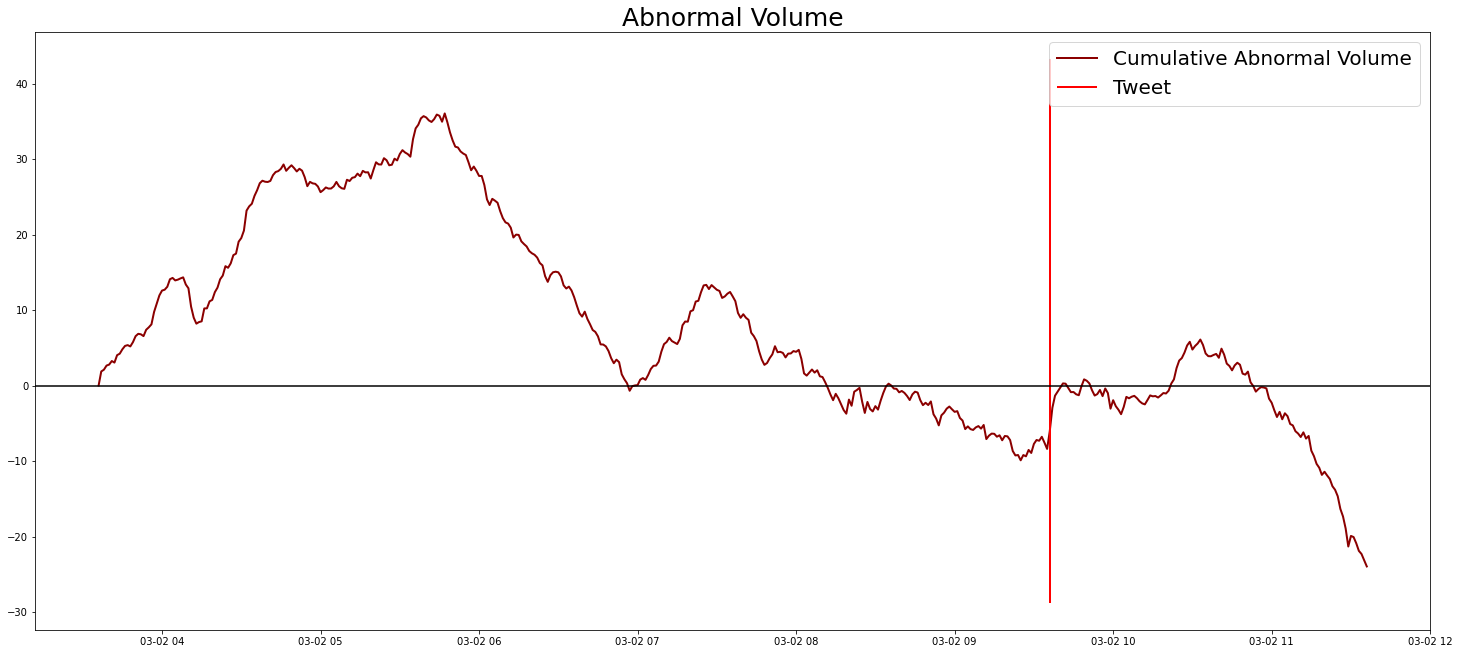

C:\Users\ckopp\AppData\Local\Temp\ipykernel_7308\1871894440.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doge_sliced["log_vol"] = np.log(doge_sliced['Quote Asset Volume']+1)
C:\Users\ckopp\AppData\Local\Temp\ipykernel_7308\1871894440.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doge_sliced['cum_log_vol'] = np.cumsum(doge_sliced['log_vol'])
C:\Users\ckopp\AppData\Local\Temp\ipykernel_7308\1871894440.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

Expected Volume =  14.50436198469309
T[0; 1] =  22.358332194947764
T[0; 5] =  24.725463531374903
T[0; 10] =  18.422030310498332
T[0; 30] =  26.87048775708244
T[0; 60] =  19.39522044222468
T[0; 120] =  19.72701840411494


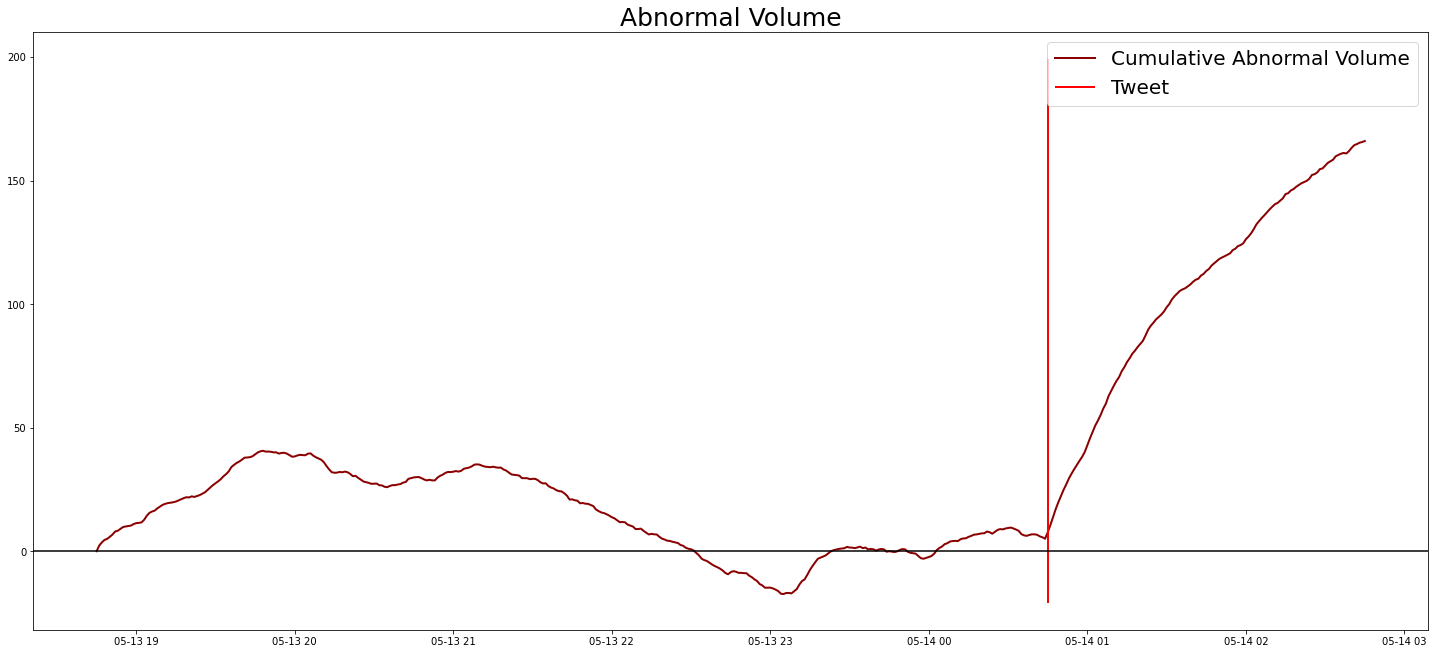

C:\Users\ckopp\AppData\Local\Temp\ipykernel_7308\1871894440.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doge_sliced["log_vol"] = np.log(doge_sliced['Quote Asset Volume']+1)
C:\Users\ckopp\AppData\Local\Temp\ipykernel_7308\1871894440.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doge_sliced['cum_log_vol'] = np.cumsum(doge_sliced['log_vol'])
C:\Users\ckopp\AppData\Local\Temp\ipykernel_7308\1871894440.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

Expected Volume =  10.51605604997544
T[0; 1] =  7.575801364056269
T[0; 5] =  4.6521815591721
T[0; 10] =  5.023277184829033
T[0; 30] =  4.245286946631067
T[0; 60] =  0.5822667730438776
T[0; 120] =  -2.8759388654391804


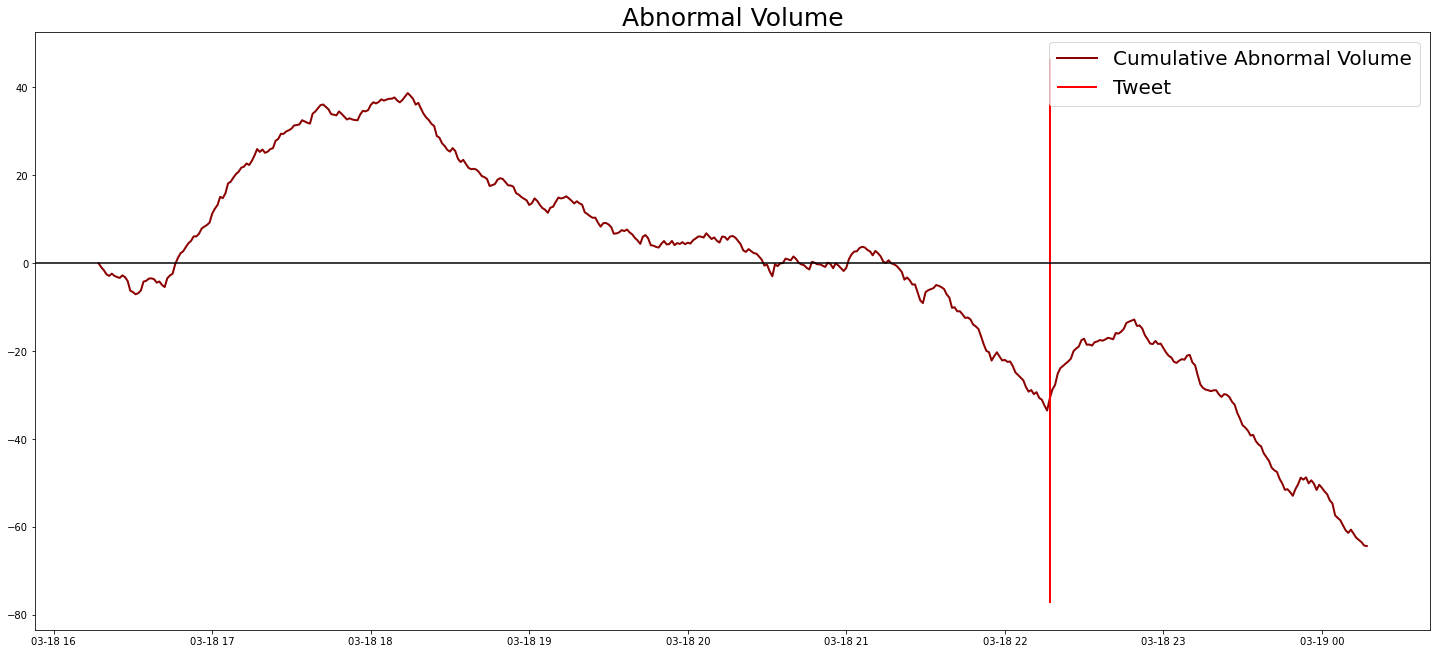

C:\Users\ckopp\AppData\Local\Temp\ipykernel_7308\1871894440.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doge_sliced["log_vol"] = np.log(doge_sliced['Quote Asset Volume']+1)
C:\Users\ckopp\AppData\Local\Temp\ipykernel_7308\1871894440.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doge_sliced['cum_log_vol'] = np.cumsum(doge_sliced['log_vol'])
C:\Users\ckopp\AppData\Local\Temp\ipykernel_7308\1871894440.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

Expected Volume =  12.559380709001278
T[0; 1] =  4.636971875528509
T[0; 5] =  2.1356814187958775
T[0; 10] =  1.1636044634338434
T[0; 30] =  -1.6190984193648794
T[0; 60] =  -2.5493175768738485
T[0; 120] =  -2.3724384376636944


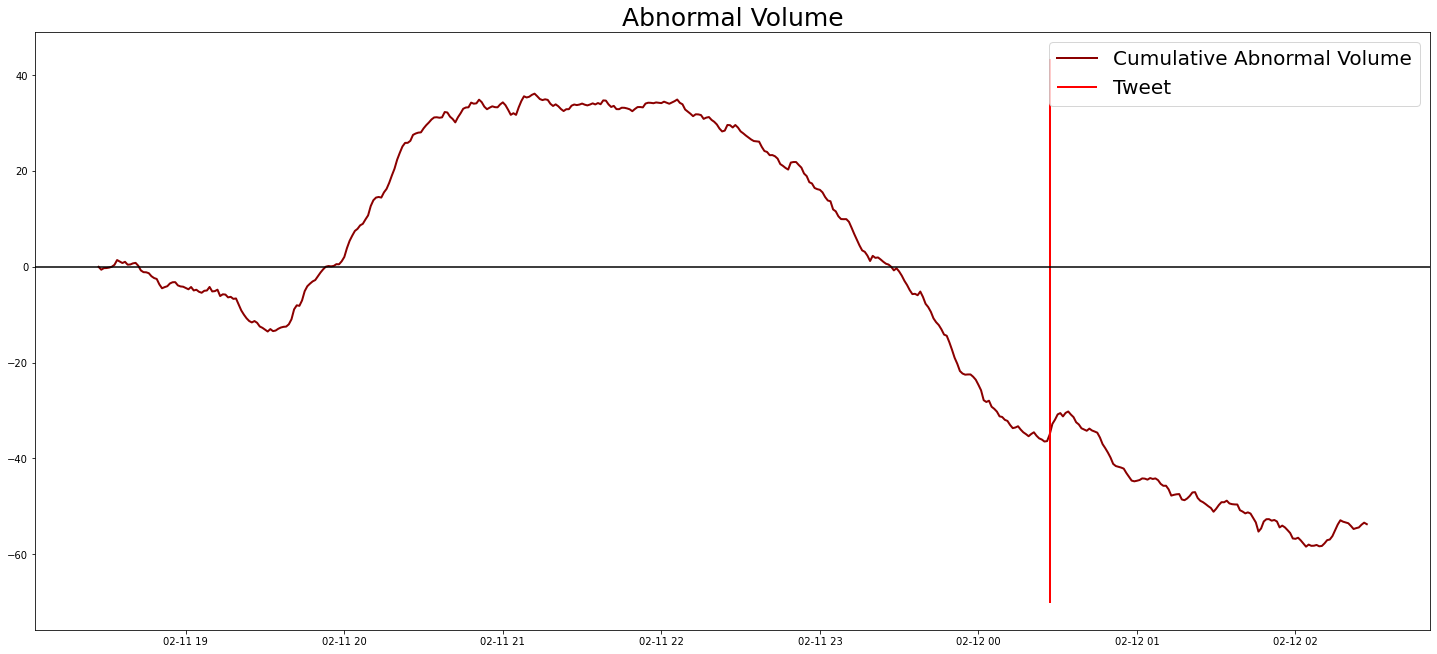

C:\Users\ckopp\AppData\Local\Temp\ipykernel_7308\1871894440.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doge_sliced["log_vol"] = np.log(doge_sliced['Quote Asset Volume']+1)
C:\Users\ckopp\AppData\Local\Temp\ipykernel_7308\1871894440.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doge_sliced['cum_log_vol'] = np.cumsum(doge_sliced['log_vol'])
C:\Users\ckopp\AppData\Local\Temp\ipykernel_7308\1871894440.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

Expected Volume =  10.336593386555846
T[0; 1] =  10.186092092217638
T[0; 5] =  34.97768591867887
T[0; 10] =  61.30678314505773
T[0; 30] =  101.08393510725536
T[0; 60] =  83.1319316185588
T[0; 120] =  108.3871193251359


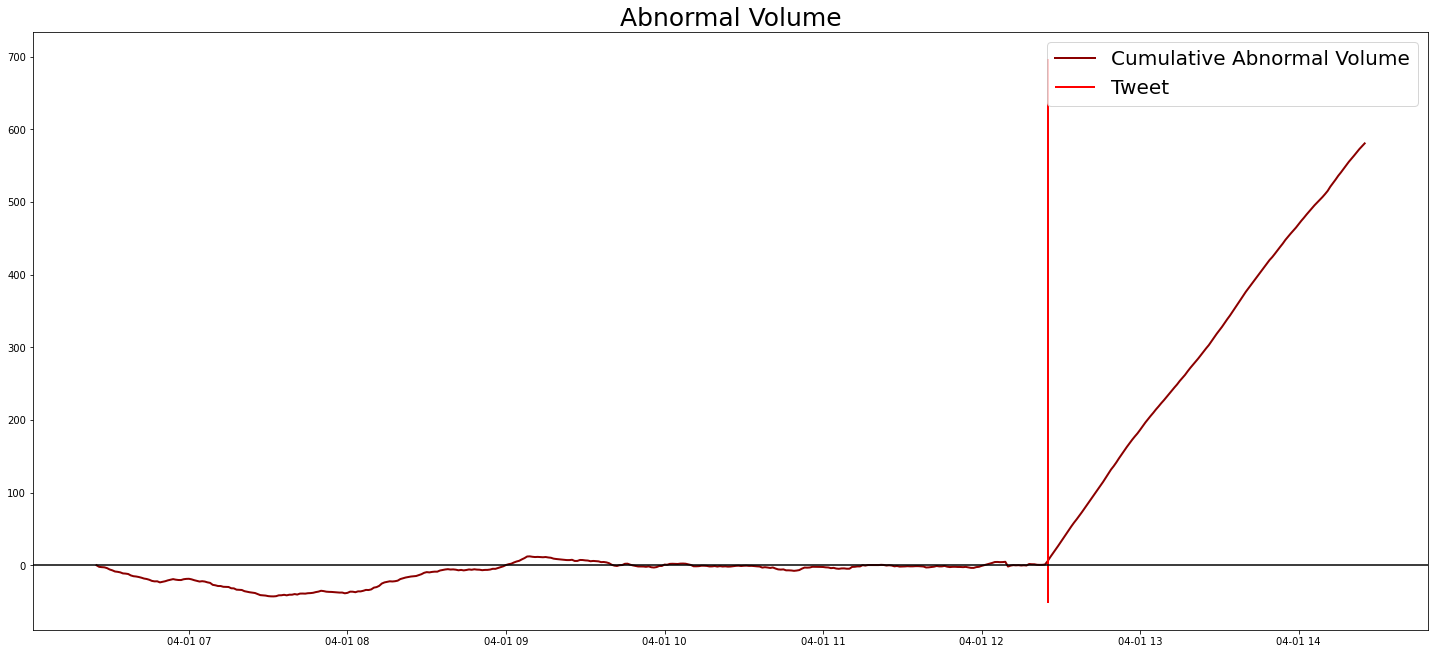

C:\Users\ckopp\AppData\Local\Temp\ipykernel_7308\1871894440.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doge_sliced["log_vol"] = np.log(doge_sliced['Quote Asset Volume']+1)
C:\Users\ckopp\AppData\Local\Temp\ipykernel_7308\1871894440.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doge_sliced['cum_log_vol'] = np.cumsum(doge_sliced['log_vol'])
C:\Users\ckopp\AppData\Local\Temp\ipykernel_7308\1871894440.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

Expected Volume =  15.800811952447022
T[0; 1] =  2.226936368912397
T[0; 5] =  6.496602889901981
T[0; 10] =  6.8570516194392175
T[0; 30] =  1.1227185605005485
T[0; 60] =  -3.367392690449569
T[0; 120] =  -8.546523310299913


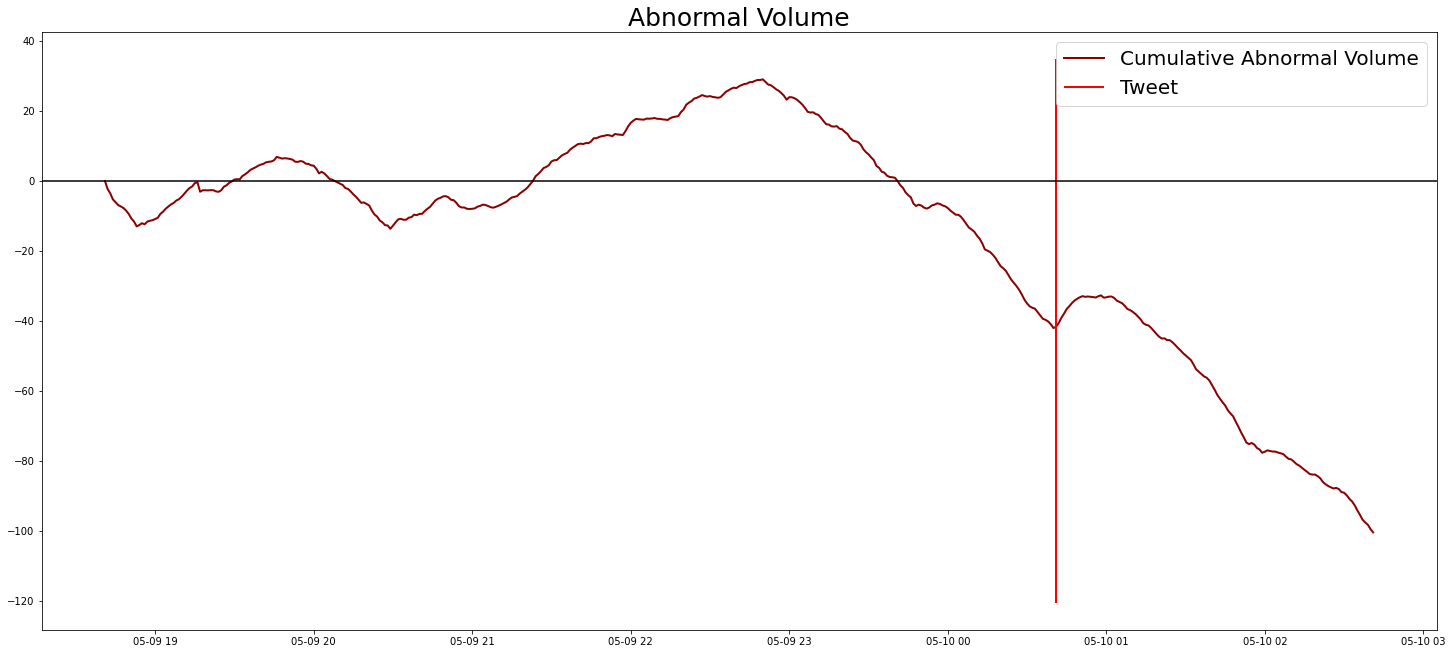

C:\Users\ckopp\AppData\Local\Temp\ipykernel_7308\1871894440.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doge_sliced["log_vol"] = np.log(doge_sliced['Quote Asset Volume']+1)
C:\Users\ckopp\AppData\Local\Temp\ipykernel_7308\1871894440.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doge_sliced['cum_log_vol'] = np.cumsum(doge_sliced['log_vol'])
C:\Users\ckopp\AppData\Local\Temp\ipykernel_7308\1871894440.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

Expected Volume =  11.172845786062167
T[0; 1] =  10.447277195380146
T[0; 5] =  25.584384746923384
T[0; 10] =  25.8177757008964
T[0; 30] =  25.940435668919854
T[0; 60] =  28.226218325737815
T[0; 120] =  23.503044026414347


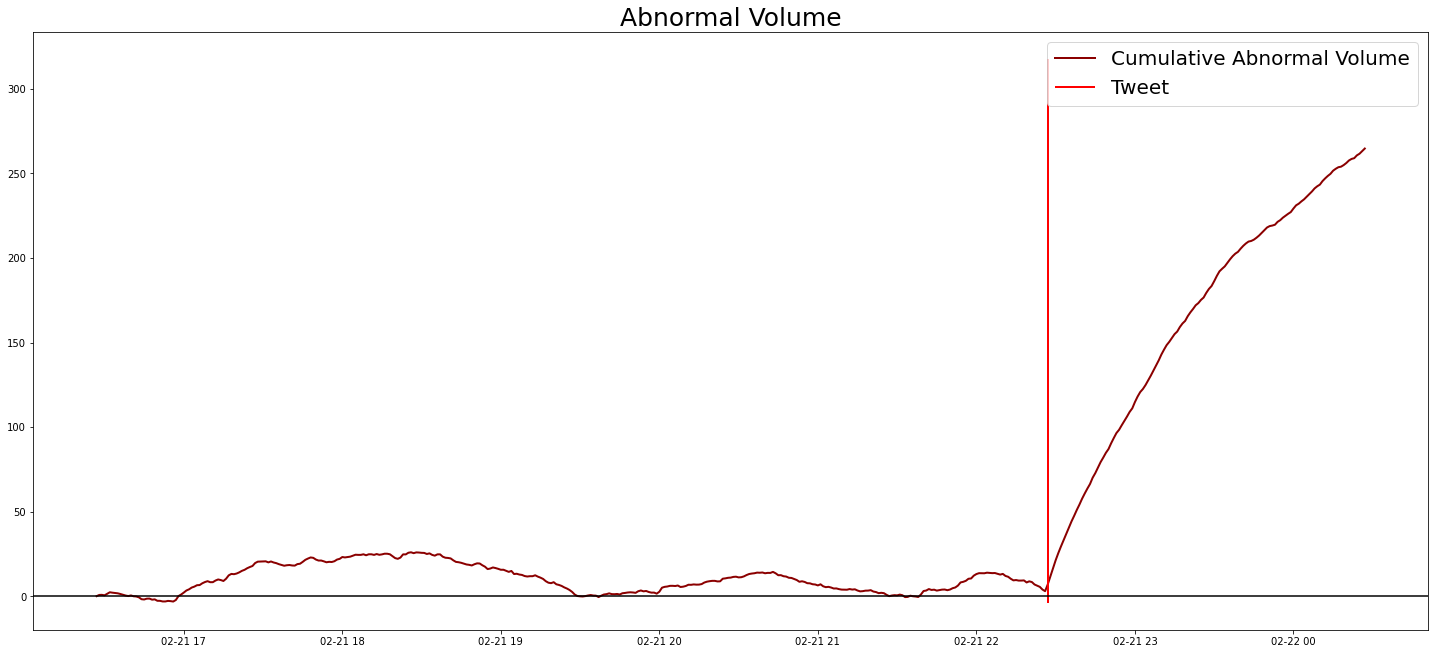

C:\Users\ckopp\AppData\Local\Temp\ipykernel_7308\1871894440.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doge_sliced["log_vol"] = np.log(doge_sliced['Quote Asset Volume']+1)
C:\Users\ckopp\AppData\Local\Temp\ipykernel_7308\1871894440.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doge_sliced['cum_log_vol'] = np.cumsum(doge_sliced['log_vol'])
C:\Users\ckopp\AppData\Local\Temp\ipykernel_7308\1871894440.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

Expected Volume =  14.533300824729773
T[0; 1] =  3.8998987602855526
T[0; 5] =  12.517388532502187
T[0; 10] =  13.571640562710753
T[0; 30] =  16.229762553749527
T[0; 60] =  15.87962610603418
T[0; 120] =  12.893628544674085


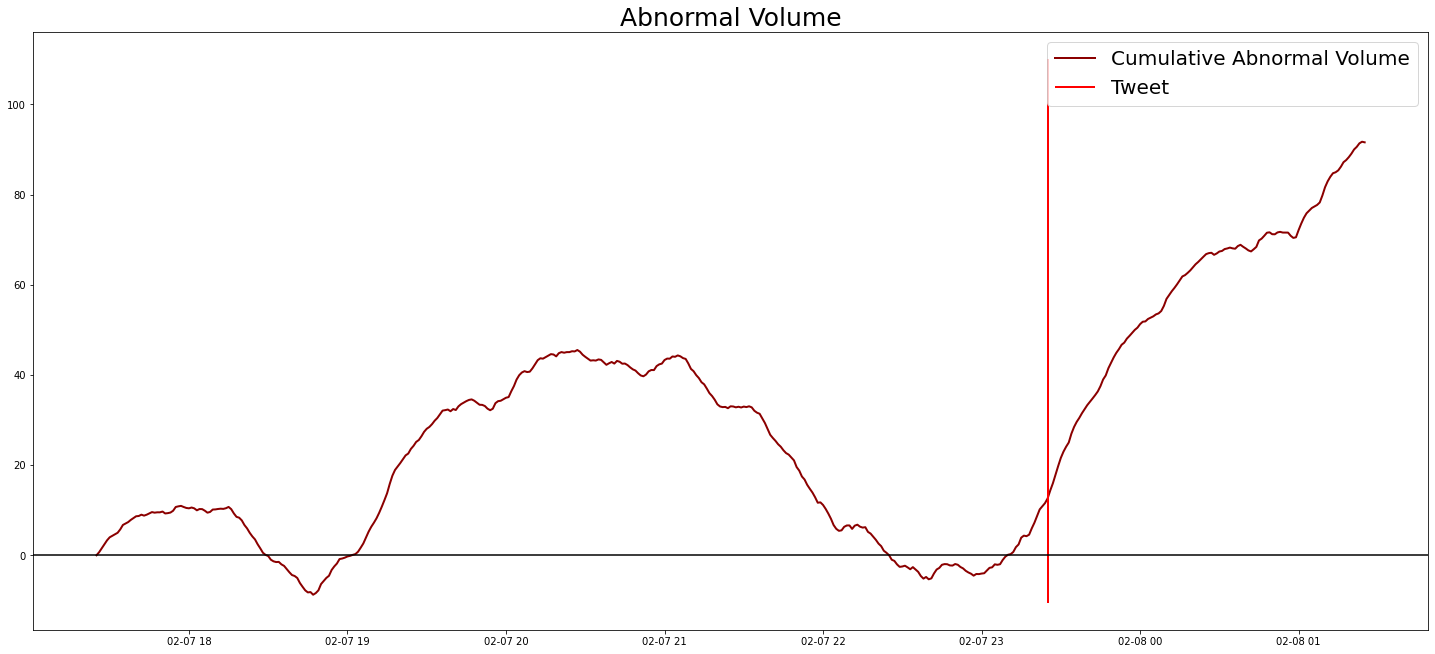

C:\Users\ckopp\AppData\Local\Temp\ipykernel_7308\1871894440.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doge_sliced["log_vol"] = np.log(doge_sliced['Quote Asset Volume']+1)
C:\Users\ckopp\AppData\Local\Temp\ipykernel_7308\1871894440.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doge_sliced['cum_log_vol'] = np.cumsum(doge_sliced['log_vol'])
C:\Users\ckopp\AppData\Local\Temp\ipykernel_7308\1871894440.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

Expected Volume =  5.829972181393689
T[0; 1] =  22.430448820148566
T[0; 5] =  35.386461708033785
T[0; 10] =  57.32008281952194
T[0; 30] =  76.42401782699186
T[0; 60] =  95.96655025948681
T[0; 120] =  72.98786094773241


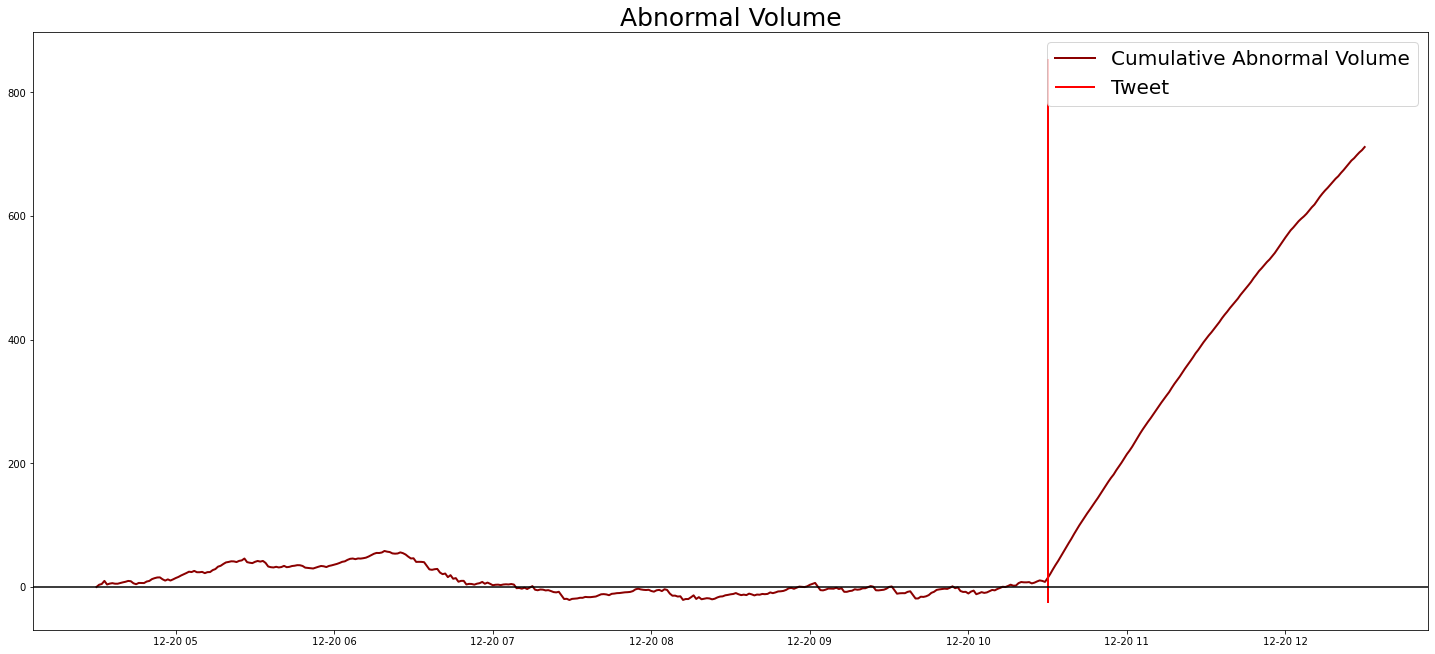

atv_frame:
       ATV_0     ATV_1     ATV_2     ATV_3     ATV_4     ATV_5     ATV_6  \
0   3.292432  4.155803   3.23209  3.480002  2.609275  2.672897   2.50621   
1   -0.15567 -0.037439 -0.375953 -0.921495 -0.111678 -0.080502 -0.550966   
2   1.874914  2.898646  0.484987  0.524015  0.941335   1.65028  1.593642   
3   4.396271   4.23138  4.334257  3.601449  3.199465  3.540902  3.088518   
4   0.059988 -0.311875 -0.884763 -0.835273 -1.329524 -0.600624  0.044929   
5   2.247959  4.001426  3.672754  3.693439  3.609508  3.663954  3.327888   
6    2.13907  3.137776  3.819551  3.635359  3.285445  3.741358  4.115272   
7   1.129964  2.185981  1.662406  0.694609 -3.734327  0.837668  1.711276   
8   2.187653  2.831352  3.250391  3.236803  3.167201  3.146004  3.024279   
9   2.519605  1.551786  1.018571  0.762931  0.497574   1.05424  0.650023   
10  2.328392  3.124918  1.596368  0.544999  0.543791  0.537101  -0.03541   
11  2.637667  2.884659  3.179358  3.248292  2.805084  2.536524  2.527551   
1

In [ ]:
# Volume
df['Date'] = df['timestamp'].apply(lambda x: dt.fromtimestamp(x))


atv_ges = pd.DataFrame(columns=['ATV_0', 'ATV_1', 'ATV_2', 'ATV_3', 'ATV_4', 'ATV_5', 'ATV_6', 'ATV_7', 'ATV_8', 'ATV_9', 'ATV_10'])
catv_ges = pd.DataFrame(columns = ['CATV_1', 'CATV_2', 'CATV_5', 'CATV_10', 'CATV_30', 'CATV_60', 'CATV_120'])

cum_abnormal_volume_all = []

for _, tweet in df_tweets_relevant.iterrows():
    timestamp = tweet['timestamp']
    doge_sliced = df[(df['timestamp'] >= timestamp-360*60) & (df['timestamp'] <= timestamp+120*60)]
    # Es werden nach Tweets gesucht, die 240 Minuten vor und 100 Minuten nach dem Event stattgefunden haben.
    tweets_sliced = df_tweets[(df_tweets['timestamp'] >= timestamp-240*60) & (df_tweets['timestamp'] <= timestamp+100*60)]
    
    # Ausrechnen der Renditen
    doge_sliced["log_vol"] = np.log(doge_sliced['Quote Asset Volume']+1)
    
    ###################################################################################################################
    # Kumulierte Renditen
    doge_sliced['cum_log_vol'] = np.cumsum(doge_sliced['log_vol'])
    ###################################################################################################################

    # Expected Volume which are based on the mean value of the returns of the last 5 hours before the tweet.
    # Event Takes place at t=360
    expected_volume = np.mean(doge_sliced['log_vol'].iloc[:301]) # Fehler bei Ante, da Ante 1:301 nimmt und nicht 0:300? --> Upper bound excluded
    print('Expected Volume = ', expected_volume)
    
    # Abnormal Returns based on After Returns - Mean Value of Returns (before Tweet)
    doge_sliced['abnormal_volume'] = doge_sliced['log_vol'] - expected_volume
    doge_sliced['abnormal_volume_cum'] = np.cumsum(doge_sliced['abnormal_volume'])
    doge_sliced['abnormal_volume_cum'].iloc[0] = 0
    
    cum_abnormal_volume_all.append(doge_sliced['log_vol'].values)

    atv_values = []
    for event_horizon in range(11):
        atv_values.append(doge_sliced['abnormal_volume'].iloc[360+event_horizon])
    atv_ges = pd.concat([atv_ges, pd.DataFrame([atv_values], columns=atv_ges.columns)], ignore_index=True)


    catv_values = []
    for event_horizon in [1, 2, 5, 10, 30, 60, 120]:
        catv_values.append(doge_sliced['abnormal_volume'].iloc[360:360+event_horizon+1].sum())
    catv_ges = pd.concat([catv_ges, pd.DataFrame([catv_values], columns=catv_ges.columns)], ignore_index=True)

    # T-Statistiken für [1, 5, 10, 30, 60, 120]
    for event_horizon in [1, 5, 10, 30, 60, 120]:
        print(f'T[0; {event_horizon}] = ', (doge_sliced['abnormal_volume'].iloc[360:360+event_horizon+1].mean() / doge_sliced['abnormal_volume'].iloc[360:360+event_horizon+1].std()) * np.sqrt(event_horizon+1)) # <-- richtiger Wert
        
    fig = plt.figure(1, figsize = (25, 11))
    # plt.plot(doge_sliced["Date"], doge_sliced['cum_log_vol'], lw=2, label='Cumulative Volume')
    plt.plot(doge_sliced["Date"], doge_sliced['abnormal_volume_cum'], lw=2, label='Cumulative Abnormal Volume', color='darkred')
    plt.vlines(dt.fromtimestamp(timestamp), label='Tweet', ymin=doge_sliced['abnormal_volume_cum'].min()*1.2, ymax=doge_sliced['abnormal_volume_cum'].max()*1.2, colors='red', lw=2) 

    if len(tweets_sliced) > 1:
        plt.vlines([dt.fromtimestamp(i) for i in tweets_sliced['timestamp'] if i != timestamp], label='Other Tweets', ymin=0, ymax=doge_sliced['abnormal_volume_cum'].max()*1.2, colors='orange', lw=2) 
    plt.axhline(0, color = 'black')
    plt.legend(loc='best', fontsize=20)
    plt.title('Abnormal Volume', size=25)

    plt.show()

print('atv_frame:')
print(atv_ges)

print('catv_frame:')
print(catv_ges)

In [ ]:
for s in atv_ges.columns:
    print(s)
    print('mean: ', atv_ges[s].mean())
    print('pos: ', sum(atv_ges[s] > 0) / len(atv_ges[s]))
    print('t-stat: ', atv_ges[s].mean() / atv_ges[s].std() * np.sqrt(len(atv_ges[s])))

    test_statistic, p_value = wilcoxon(atv_ges[s], method='exact', alternative='two-sided')

    # Gib die Teststatistik und den p-Wert aus
    print("z-stat:", test_statistic)
    print("p-Wert:", p_value)
    print(np.round(atv_ges[s].mean(), 3), ' & ', 
          np.round(atv_ges[s].mean() / atv_ges[s].std() * np.sqrt(len(atv_ges[s])), 2), ' & ',
          np.round(test_statistic, 2), ' & ',
          int(np.round(sum(atv_ges[s] > 0) / len(atv_ges[s])*100, 0)), '\% & ', sep='')
    print('\n')

ATV_0
mean:  2.367282272053822
pos:  0.9473684210526315
t-stat:  6.3647353794942765
z-stat: 2.0
p-Wert: 1.1444091796875e-05
2.367 & 6.36 & 2.0 & 95\% & 


ATV_1
mean:  2.8905675093236236
pos:  0.8947368421052632
t-stat:  7.040476575333272
z-stat: 3.0
p-Wert: 1.9073486328125e-05
2.891 & 7.04 & 3.0 & 89\% & 


ATV_2
mean:  2.4839597864406193
pos:  0.8947368421052632
t-stat:  5.200953743433281
z-stat: 4.0
p-Wert: 2.6702880859375e-05
2.484 & 5.2 & 4.0 & 89\% & 


ATV_3
mean:  2.3848448320421656
pos:  0.8947368421052632
t-stat:  4.960294028925011
z-stat: 11.0
p-Wert: 0.000209808349609375
2.385 & 4.96 & 11.0 & 89\% & 


ATV_4
mean:  1.9192580635463443
pos:  0.8421052631578947
t-stat:  3.488038283216353
z-stat: 25.0
p-Wert: 0.0033416748046875
1.919 & 3.49 & 25.0 & 84\% & 


ATV_5
mean:  2.1931104369754353
pos:  0.8421052631578947
t-stat:  4.560748372050669
z-stat: 10.0
p-Wert: 0.000164031982421875
2.193 & 4.56 & 10.0 & 84\% & 


ATV_6
mean:  2.209191122516295
pos:  0.8947368421052632
t-stat: 

In [ ]:
for s in catv_ges.columns:
    print(s)
    print('mean: ', catv_ges[s].mean())
    print('pos: ', sum(catv_ges[s] > 0) / len(catv_ges[s]))
    print('t-stat: ', catv_ges[s].mean() / catv_ges[s].std() * np.sqrt(len(catv_ges[s])))

    test_statistic, p_value = wilcoxon(catv_ges[s], method='exact', alternative='two-sided')

    # Gib die Teststatistik und den p-Wert aus
    print("z-stat:", test_statistic)
    print("p-Wert:", p_value)
    print(np.round(catv_ges[s].mean(), 3), ' & ', 
          np.round(catv_ges[s].mean() / catv_ges[s].std() * np.sqrt(len(catv_ges[s])), 2), ' & ',
          np.round(test_statistic, 2), ' & ',
          int(np.round(sum(catv_ges[s] > 0) / len(catv_ges[s])*100, 0)), '\% & ', sep='')
    print('\n')

CATV_1
mean:  5.257849781377446
pos:  0.8947368421052632
t-stat:  6.842833114156101
z-stat: 3.0
p-Wert: 1.9073486328125e-05
5.258 & 6.84 & 3.0 & 89\% & 


CATV_2
mean:  7.741809567818064
pos:  0.8947368421052632
t-stat:  6.336044071459715
z-stat: 3.0
p-Wert: 1.9073486328125e-05
7.742 & 6.34 & 3.0 & 89\% & 


CATV_5
mean:  14.23902290038201
pos:  0.8947368421052632
t-stat:  5.400111020703996
z-stat: 4.0
p-Wert: 2.6702880859375e-05
14.239 & 5.4 & 4.0 & 89\% & 


CATV_10
mean:  24.115929107453635
pos:  0.8947368421052632
t-stat:  4.782791275750963
z-stat: 5.0
p-Wert: 3.814697265625e-05
24.116 & 4.78 & 5.0 & 89\% & 


CATV_30
mean:  54.88398552637325
pos:  0.7894736842105263
t-stat:  3.745961746790101
z-stat: 22.0
p-Wert: 0.00202178955078125
54.884 & 3.75 & 22.0 & 79\% & 


CATV_60
mean:  87.02346556014975
pos:  0.6842105263157895
t-stat:  3.1265159211730116
z-stat: 34.0
p-Wert: 0.012359619140625
87.023 & 3.13 & 34.0 & 68\% & 


CATV_120
mean:  134.1548360240926
pos:  0.5789473684210527
t-

In [ ]:
atv_total = pd.concat([atv_ges, pd.read_csv('atv_ges_bitcoin.csv')], ignore_index=True)
catv_total = pd.concat([catv_ges, pd.read_csv('catv_ges_bitcoin.csv')], ignore_index=True)

In [ ]:
for s in atv_total.columns:
    print(s)
    print('mean: ', atv_total[s].mean())
    print('pos: ', sum(atv_total[s] > 0) / len(atv_total[s]))
    print('t-stat: ', atv_total[s].mean() / atv_total[s].std() * np.sqrt(len(atv_total[s])))

    test_statistic, p_value = wilcoxon(atv_total[s], method='exact', alternative='two-sided')

    # Gib die Teststatistik und den p-Wert aus
    print("z-stat:", test_statistic)
    print("p-Wert:", p_value)
    print(np.round(atv_total[s].mean(), 3), ' & ', 
          np.round(atv_total[s].mean() / atv_total[s].std() * np.sqrt(len(atv_total[s])), 2), ' & ',
          np.round(test_statistic, 2), ' & ',
          int(np.round(sum(atv_total[s] > 0) / len(atv_total[s])*100, 0)), '\% & ', sep='')
    print('\n')

ATV_0
mean:  1.7236221886494598
pos:  0.8
t-stat:  4.668183630095679
z-stat: 27.0
p-Wert: 7.49826431274414e-05
1.724 & 4.67 & 27.0 & 80\% & 


ATV_1
mean:  2.1937249277855817
pos:  0.8
t-stat:  5.362016607543337
z-stat: 22.0
p-Wert: 3.1948089599609375e-05
2.194 & 5.36 & 22.0 & 80\% & 


ATV_2
mean:  1.981253882431816
pos:  0.84
t-stat:  4.737801081715101
z-stat: 22.0
p-Wert: 3.1948089599609375e-05
1.981 & 4.74 & 22.0 & 84\% & 


ATV_3
mean:  1.8604555949122619
pos:  0.72
t-stat:  4.415922614087836
z-stat: 38.0
p-Wert: 0.0003764033317565918
1.86 & 4.42 & 38.0 & 72\% & 


ATV_4
mean:  1.5024233585390006
pos:  0.8
t-stat:  3.3695585759786777
z-stat: 49.0
p-Wert: 0.0014527440071105957
1.502 & 3.37 & 49.0 & 80\% & 


ATV_5
mean:  1.6639124324093086
pos:  0.76
t-stat:  3.940478361595046
z-stat: 43.0
p-Wert: 0.0007149577140808105
1.664 & 3.94 & 43.0 & 76\% & 


ATV_6
mean:  1.6800649460479433
pos:  0.76
t-stat:  4.106843457876099
z-stat: 34.0
p-Wert: 0.00021690130233764648
1.68 & 4.11 & 34.0 

In [ ]:
for s in catv_total.columns:
    print(s)
    print('mean: ', catv_total[s].mean())
    print('pos: ', sum(catv_total[s] > 0) / len(catv_total[s]))
    print('t-stat: ', catv_total[s].mean() / catv_total[s].std() * np.sqrt(len(catv_total[s])))

    test_statistic, p_value = wilcoxon(catv_total[s], method='exact', alternative='two-sided')

    # Gib die Teststatistik und den p-Wert aus
    print("z-stat:", test_statistic)
    print("p-Wert:", p_value)
    print(np.round(catv_total[s].mean(), 3), ' & ', 
          np.round(catv_total[s].mean() / catv_total[s].std() * np.sqrt(len(catv_total[s])), 2), ' & ',
          np.round(test_statistic, 2), ' & ',
          int(np.round(sum(catv_total[s] > 0) / len(catv_total[s])*100, 0)), '\% & ', sep='')
    print('\n')

CATV_1
mean:  3.917347116435041
pos:  0.8
t-stat:  5.1075832580930145
z-stat: 23.0
p-Wert: 3.814697265625e-05
3.917 & 5.11 & 23.0 & 80\% & 


CATV_2
mean:  5.898600998866856
pos:  0.8
t-stat:  5.093050828601107
z-stat: 24.0
p-Wert: 4.5418739318847656e-05
5.899 & 5.09 & 24.0 & 80\% & 


CATV_5
mean:  10.925392384727429
pos:  0.8
t-stat:  4.615998402133577
z-stat: 27.0
p-Wert: 7.49826431274414e-05
10.925 & 4.62 & 27.0 & 80\% & 


CATV_10
mean:  18.69829660955314
pos:  0.76
t-stat:  4.285159249001827
z-stat: 28.0
p-Wert: 8.803606033325195e-05
18.698 & 4.29 & 28.0 & 76\% & 


CATV_30
mean:  41.39215777101355
pos:  0.68
t-stat:  3.369470477388812
z-stat: 63.0
p-Wert: 0.006129205226898193
41.392 & 3.37 & 63.0 & 68\% & 


CATV_60
mean:  65.49446294842014
pos:  0.64
t-stat:  2.884168575774621
z-stat: 83.0
p-Wert: 0.03180783987045288
65.494 & 2.88 & 83.0 & 64\% & 


CATV_120
mean:  100.0675523710336
pos:  0.52
t-stat:  2.4442378365277957
z-stat: 95.0
p-Wert: 0.0709836483001709
100.068 & 2.44 & 

***Market Model***

In [ ]:
# Market Model
ar_ges_market = pd.DataFrame(columns=['AR_0', 'AR_1', 'AR_2', 'AR_3', 'AR_4', 'AR_5', 'AR_6', 'AR_7', 'AR_8', 'AR_9', 'AR_10', ])
car_ges_market = pd.DataFrame(columns = ['CAR_1', 'CAR_2', 'CAR_5', 'CAR_10', 'CAR_30', 'CAR_60', 'CAR_120'])


for _, tweet in df_tweets_relevant.iterrows():

    timestamp = tweet['timestamp']
    doge_sliced = df[(df['timestamp'] >= timestamp-360*60) & (df['timestamp'] <= timestamp+120*60)]
    btc_sliced = df_btc[(df_btc['timestamp'] >= timestamp-360*60) & (df_btc['timestamp'] <= timestamp+120*60)]

    # Ausrechnen der Renditen
    doge_returns = np.log(doge_sliced['Close'] / doge_sliced['Close'].shift(1)).values
    btc_returns = np.log(btc_sliced['Close'] / btc_sliced['Close'].shift(1)).values

    doge_returns[0] = 0
    btc_returns[0] = 0

    doge_estimation = doge_returns[1:301]
    btc_estimation = btc_returns[1:301]

    x = btc_estimation.reshape(-1, 1)
    y = doge_estimation.reshape(-1, 1)
    model = LinearRegression().fit(x, y)

    residuals = y - model.predict(x)
    
    # constant column to exogenous variables, in order to perform white's test
    x_with_constant = np.column_stack((np.ones_like(x), x))
        
    # White‘s test for heteroscedasticity
    white_test = het_white(residuals, x_with_constant)
        
    # Shapiro-Wilk-Test for Normality
    shapiro_test = shapiro(residuals)
        
    # Durbin-Watson test for first-order autocorrelation
    dw_test = durbin_watson(residuals)

    # print("white's test (heterosc.), p-value:", white_test[1])
    # print("Shapiro-Wilk-Test (norm.), p-value:", shapiro_test.pvalue)
    # print("Durbin-Watson test (autocorr.):", dw_test)
    # print(''.join(['v']*20), sep='')
    print(' & ', np.round(white_test[1], 4), ' & ', np.round(shapiro_test.pvalue, 4), ' & ', np.round(dw_test[0], 2), sep='')
    # print(''.join(['^']*20), sep='')

    alpha = model.intercept_
    beta = model.coef_[0]

    doge_abnormal_returns = doge_returns - (alpha + beta * btc_returns)

    ar_values = []
    for event_horizon in range(11): # Für die Minuten 0 bis 10
        ar_values.append(doge_abnormal_returns[360+event_horizon])
    ar_ges_market = pd.concat([ar_ges_market, pd.DataFrame([ar_values], columns=ar_ges_market.columns)], ignore_index=True)

    car_values = []
    for event_horizon in [1, 2, 5, 10, 30, 60, 120]:
        car_values.append(doge_abnormal_returns[360:360+event_horizon+1].sum())
    car_ges_market = pd.concat([car_ges_market, pd.DataFrame([car_values], columns=car_ges_market.columns)], ignore_index=True)

    # T-Statistiken für [1, 5, 10, 30, 60, 120]
    # for event_horizon in [1, 5, 10, 30, 60, 120]:
        # print(np.round(doge_abnormal_returns[360:360+event_horizon+1].sum()*100, 4), '\% & ', np.round((doge_abnormal_returns[360:360+event_horizon+1].mean() / doge_abnormal_returns[360:360+event_horizon+1].std()) * np.sqrt(event_horizon+1), 2), ' & ', sep='')
        # print(f'T[0; {event_horizon}] = ', np.round((doge_abnormal_returns[360:360+event_horizon+1].mean() / doge_abnormal_returns[360:360+event_horizon+1].std()) * np.sqrt(event_horizon+1), 4)) # <-- richtiger Wert
    # print('\n')
    
# print(ar_ges_market)
# print(car_ges_market)

 & 0.6207 & 0.0 & 2.17
 & 0.5821 & 0.0 & 1.68


 & 0.003 & 0.0 & 2.2
 & 0.2942 & 0.0004 & 2.14
 & 0.323 & 0.0 & 1.78
 & 0.0899 & 0.0 & 2.2
 & 0.0095 & 0.4374 & 2.19
 & 0.3878 & 0.0017 & 2.32
 & 0.8043 & 0.0 & 1.97
 & 0.0072 & 0.0 & 2.32
 & 0.6948 & 0.001 & 1.96
 & 0.8989 & 0.0 & 1.79
 & 0.0 & 0.0 & 2.18
 & 0.9229 & 0.0 & 2.27
 & 0.217 & 0.0 & 2.17
 & 0.9867 & 0.0033 & 1.74
 & 0.6539 & 0.0 & 2.26
 & 0.0748 & 0.0 & 1.91
 & 0.0321 & 0.0073 & 2.45


In [ ]:
for s in ar_ges_market.columns:
    print(s)
    print('mean: ', ar_ges_market[s].mean())
    print('pos: ', sum(ar_ges_market[s] > 0) / len(ar_ges_market[s]))
    print('t-stat: ', ar_ges_market[s].mean() / ar_ges_market[s].std() * np.sqrt(len(ar_ges_market[s])))

    test_statistic, p_value = wilcoxon(ar_ges_market[s], method='exact', alternative='two-sided')

    # Gib die Teststatistik und den p-Wert aus
    print("z-stat:", test_statistic)
    print("p-Wert:", p_value)
    print(np.round(ar_ges_market[s].mean()*100, 4), '\% & ', 
          np.round(ar_ges_market[s].mean() / ar_ges_market[s].std() * np.sqrt(len(ar_ges_market[s])), 2), ' & ',
          np.round(test_statistic, 2), ' & ',
          int(np.round(sum(ar_ges_market[s] > 0) / len(ar_ges_market[s])*100, 0)), '\%', sep='')
    print('\n')

AR_0
mean:  0.018600174874383247
pos:  0.9473684210526315
t-stat:  5.78066987852888
z-stat: 1.0
p-Wert: 7.62939453125e-06
1.86\% & 5.78 & 1.0 & 95\%


AR_1
mean:  0.016126940368103183
pos:  0.6842105263157895
t-stat:  3.67444906998777
z-stat: 29.0
p-Wert: 0.0061798095703125
1.6127\% & 3.67 & 29.0 & 68\%


AR_2
mean:  0.007876152998375201
pos:  0.631578947368421
t-stat:  2.3836280353867774
z-stat: 51.0
p-Wert: 0.07987594604492188
0.7876\% & 2.38 & 51.0 & 63\%


AR_3
mean: 

 0.0024895110044337075
pos:  0.5263157894736842
t-stat:  0.7056126717298133
z-stat: 82.0
p-Wert: 0.6225624084472656
0.249\% & 0.71 & 82.0 & 53\%


AR_4
mean:  0.0017346297280059983
pos:  0.5263157894736842
t-stat:  0.68608467153433
z-stat: 78.0
p-Wert: 0.5152778625488281
0.1735\% & 0.69 & 78.0 & 53\%


AR_5
mean:  -0.0005121929928527046
pos:  0.5263157894736842
t-stat:  -0.20215541749717744
z-stat: 85.0
p-Wert: 0.70855712890625
-0.0512\% & -0.2 & 85.0 & 53\%


AR_6
mean:  -0.0003792889015792845
pos:  0.42105263157894735
t-stat:  -0.22232946894377742
z-stat: 81.0
p-Wert: 0.5948867797851562
-0.0379\% & -0.22 & 81.0 & 42\%


AR_7
mean:  0.0031207351353189235
pos:  0.5789473684210527
t-stat:  1.3766109908973394
z-stat: 76.0
p-Wert: 0.4653167724609375
0.3121\% & 1.38 & 76.0 & 58\%


AR_8
mean:  -0.0013554355308737775
pos:  0.47368421052631576
t-stat:  -0.6156644745628959
z-stat: 81.0
p-Wert: 0.5948867797851562
-0.1355\% & -0.62 & 81.0 & 47\%


AR_9
mean:  -0.001487630999848041
pos:  0.31578

In [ ]:
for s in car_ges_market.columns:
    print(s)
    print('mean: ', car_ges_market[s].mean())
    print('pos: ', sum(car_ges_market[s] > 0) / len(car_ges_market[s]))
    print('t-stat: ', car_ges_market[s].mean() / car_ges_market[s].std() * np.sqrt(len(car_ges_market[s])))

    test_statistic, p_value = wilcoxon(car_ges_market[s], method='exact', alternative='two-sided')

    # Gib die Teststatistik und den p-Wert aus
    print("z-stat:", test_statistic)
    print("p-Wert:", p_value)
    print(np.round(car_ges_market[s].mean()*100, 4), '\% & ', 
          np.round(car_ges_market[s].mean() / car_ges_market[s].std() * np.sqrt(len(car_ges_market[s])), 2), ' & ',
          np.round(test_statistic, 2), ' & ',
          int(np.round(sum(car_ges_market[s] > 0) / len(car_ges_market[s])*100, 0)), '\%', sep='')
    print('\n')

CAR_1
mean:  0.03472711524248643
pos:  0.8421052631578947
t-stat:  4.7812896052369025
z-stat: 7.0
p-Wert: 7.2479248046875e-05
3.4727\% & 4.78 & 7.0 & 84\%


CAR_2
mean:  0.042603268240861636
pos:  0.8947368421052632
t-stat:  4.313248097041642
z-stat: 4.0
p-Wert: 2.6702880859375e-05
4.2603\% & 4.31 & 4.0 & 89\%


CAR_5
mean:  0.04631521598044863
pos:  0.8421052631578947
t-stat:  4.4421635131125035
z-stat: 6.0
p-Wert: 5.340576171875e-05
4.6315\% & 4.44 & 6.0 & 84\%


CAR_10
mean:  0.050969958077555895
pos:  0.8421052631578947
t-stat:  3.768700028048169
z-stat:

 18.0
p-Wert: 0.000965118408203125
5.097\% & 3.77 & 18.0 & 84\%


CAR_30
mean:  0.04588050925414531
pos:  0.7894736842105263
t-stat:  3.0756230924959786
z-stat: 35.0
p-Wert: 0.014068603515625
4.5881\% & 3.08 & 35.0 & 79\%


CAR_60
mean:  0.04371993179665392
pos:  0.7368421052631579
t-stat:  2.9175255070553825
z-stat: 38.0
p-Wert: 0.020412445068359375
4.372\% & 2.92 & 38.0 & 74\%


CAR_120
mean:  0.03152777221085533
pos:  0.6842105263157895
t-stat:  2.0433081888247746
z-stat: 48.0
p-Wert: 0.060207366943359375
3.1528\% & 2.04 & 48.0 & 68\%


